# Uploading conllu files for analysis

In [2]:
from google.colab import files
uploaded = files.upload()

Saving conllu_file.zip to conllu_file.zip


In [3]:

import zipfile, os

zip_path = "/content/conllu_file.zip"  # adjust if you used a different name
extract_path = "/content/conllu"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Files extracted to:", extract_path)



✅ Files extracted to: /content/conllu


# Adding conllu statistics to each file

In [4]:
import os
import csv
import re

# --- user-provided stats function ---
def conllu_stats(path):
    n_tokens = 0
    n_sentences = 0
    n_pairs = 0

    with open(path, "r", encoding="utf-8") as f:
        text_buffer = None
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("# sent_id"):
                n_sentences += 1
                text_buffer = None  # reset for next sentence
            elif line.startswith("# text"):
                text_buffer = line.split("=", 1)[1].strip()
                # simple heuristic: split on sentence-ending punctuation
                splits = re.split(r'[.!?]', text_buffer)
                if len([s for s in splits if s.strip()]) > 1:
                    n_pairs += 1
            elif line[0].isdigit():
                if "-" not in line.split("\t")[0]:
                    n_tokens += 1

    return n_tokens, n_sentences, n_pairs


# --- helper to create stats comment block ---
def make_stats_block(tokens, sentences, pairs):
    return [
        "# conllu_stats: begin",
        f"# conllu_tokens: {tokens}",
        f"# conllu_sentences: {sentences}",
        f"# Average tokens per sentence: {tokens/sentences if sentences else 0.0}",
        f"# sentence_pairs: {pairs}",
        "# conllu_stats: end",
        ""  # blank line separating header from file content
    ]


# --- main function ---
def prepend_stats_to_conllu_dir(root_dir="conllu", backup=True, file_exts=(".conllu", ".conll"), write_csv=True):
    """
    Walks `root_dir` recursively, computes stats for each .conllu/.conll file,
    prepends a stats block, and writes all results to a CSV summary file.
    """
    updated_files = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        dirnames.sort()      # ensure consistent traversal order
        filenames.sort()     # ensure files processed alphabetically

        for fname in filenames:
            if not fname.lower().endswith(file_exts):
                continue
            path = os.path.join(dirpath, fname)

            # compute stats
            tokens, sentences, pairs = conllu_stats(path)
            stats_block = make_stats_block(tokens, sentences, pairs)

            # read file
            with open(path, "r", encoding="utf-8") as f:
                lines = f.read().splitlines()

            # remove existing stats block if present
            start_idx = end_idx = None
            for i, line in enumerate(lines[:50]):  # assume header in first ~50 lines
                if line.strip() == "# conllu_stats: begin":
                    start_idx = i
                    for j in range(i + 1, min(len(lines), i + 200)):
                        if lines[j].strip() == "# conllu_stats: end":
                            end_idx = j
                            break
                    break

            if start_idx is not None and end_idx is not None:
                content_after = lines[:start_idx] + lines[end_idx + 1 :]
            else:
                content_after = lines

            new_lines = stats_block + content_after

            # write file
            with open(path, "w", encoding="utf-8", newline="\n") as f:
                f.write("\n".join(new_lines))

            updated_files.append((path, tokens, sentences, pairs))

    # sort by filename path for consistent CSV order
    updated_files.sort(key=lambda x: x[0].lower())

    # --- Write CSV summary ---
    if write_csv and updated_files:
        csv_path = os.path.join(root_dir, "conllu_file_stats_summary.csv")
        with open(csv_path, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["file_path", "tokens", "sentences", "pairs"])
            for path, t, s, pr in updated_files:
                writer.writerow([path, t, s, pr])
        print(f"\nCSV summary written to: {csv_path}")

    # --- Print summary to console ---
    for p, t, s, pr in updated_files:
        print(f"Updated {p} -> tokens={t}, sentences={s}, pairs={pr}")

    if not updated_files:
        print("No .conllu/.conll files found under", root_dir)

    return updated_files


# --- Run if main ---
if __name__ == "__main__":
    root = "conllu"  # change if your folder is elsewhere
    prepend_stats_to_conllu_dir(root_dir=root, backup=True)



CSV summary written to: conllu/conllu_file_stats_summary.csv
Updated conllu/conllu_file/de/Art/Art10_de.conllu -> tokens=976, sentences=41, pairs=0
Updated conllu/conllu_file/de/Art/Art11_de.conllu -> tokens=3686, sentences=179, pairs=53
Updated conllu/conllu_file/de/Art/Art12_de.conllu -> tokens=3680, sentences=206, pairs=47
Updated conllu/conllu_file/de/Art/Art13_de.conllu -> tokens=3759, sentences=205, pairs=28
Updated conllu/conllu_file/de/Art/Art14_de.conllu -> tokens=2357, sentences=144, pairs=20
Updated conllu/conllu_file/de/Art/Art15_de.conllu -> tokens=2268, sentences=128, pairs=24
Updated conllu/conllu_file/de/Art/Art16_de.conllu -> tokens=4072, sentences=173, pairs=26
Updated conllu/conllu_file/de/Art/Art1_de.conllu -> tokens=2078, sentences=106, pairs=20
Updated conllu/conllu_file/de/Art/Art2_de.conllu -> tokens=2999, sentences=176, pairs=38
Updated conllu/conllu_file/de/Art/Art3_de.conllu -> tokens=1460, sentences=76, pairs=7
Updated conllu/conllu_file/de/Art/Art4_de.conl

# Adding conllu statistics for each Discipline

In [5]:
import os
import csv
import shutil

import re

def conllu_stats_from_lines(lines):
    """
    Count tokens, sentences, and multi-sentence 'pairs'.
    - tokens: word tokens (ignores MWTs like 1-2)
    - sentences: # sent_id occurrences
    - pairs: # of sent_ids where the #text line contains >1 sentence
    """
    n_tokens = 0
    n_sentences = 0
    n_pairs = 0

    for raw in lines:
        line = raw.strip()
        if not line:
            continue

        if line.startswith("# sent_id"):
            n_sentences += 1

        elif line.startswith("# text"):
            # check if text contains multiple sentences
            text = line.split("=", 1)[1].strip()
            splits = re.split(r'[.!?]', text)
            if len([s for s in splits if s.strip()]) > 1:
                n_pairs += 1

        elif line[0].isdigit():
            if "-" not in line.split("\t")[0]:
                n_tokens += 1

    return n_tokens, n_sentences, n_pairs


def make_stats_block(total_tokens, avg_tokens_per_file,
                     total_sentences, avg_sentences_per_file,
                     total_pairs, avg_pairs_per_file, num_files):
    """Return list of header lines (no text content)."""
    lines = [
        "# conllu_stats: begin",
        f"# conllu_num_files: {num_files}",
        f"# conllu_total_tokens: {total_tokens}",
        f"# conllu_avg_tokens_per_file: {avg_tokens_per_file:.2f}",
        f"# conllu_total_sentences: {total_sentences}",
        f"# conllu_avg_sentences_per_file: {avg_sentences_per_file:.2f}",
        f"# conllu_total_sentence_pairs: {total_pairs}",
        f"# conllu_avg_sentence_pairs_per_file: {avg_pairs_per_file:.2f}",
        "# conllu_stats: end",
        ""  # blank line after header
    ]
    return lines

def collect_conllu_files(folder, exts=(".conllu", ".conll")):
    files = []
    for fn in sorted(os.listdir(folder)):
        lower = fn.lower()
        if lower.endswith(".bak") or lower.startswith("merged_"):
            continue
        if any(lower.endswith(ext) for ext in exts):
            files.append(os.path.join(folder, fn))
    return files

def merge_folder_stats_only(folder_path, out_name=None, backup_existing=True):
    files = collect_conllu_files(folder_path)
    num_files = len(files)
    if num_files == 0:
        return None

    total_tokens = 0
    total_sentences = 0
    total_pairs = 0


    for fpath in files:
      with open(fpath, "r", encoding="utf-8") as fh:
          lines = fh.read().splitlines()
      t, s, p = conllu_stats_from_lines(lines)
      total_tokens += t
      total_sentences += s
      total_pairs += p



    avg_tokens_per_file = (total_tokens / num_files) if num_files else 0.0
    avg_sentences_per_file = (total_sentences / num_files) if num_files else 0.0
    avg_pairs_per_file = (total_pairs / num_files) if num_files else 0.0

    folder_name = os.path.basename(os.path.normpath(folder_path))
    if out_name is None:
        out_name = f"MERGED_{folder_name}.conllu"
    out_path = os.path.join(folder_path, out_name)

    header_lines = make_stats_block(
        total_tokens=total_tokens,
        avg_tokens_per_file=avg_tokens_per_file,
        total_sentences=total_sentences,
        avg_sentences_per_file=avg_sentences_per_file,
        total_pairs=total_pairs,
        avg_pairs_per_file=avg_pairs_per_file,
        num_files=num_files
    )

    # Write ONLY the header (no text)
    with open(out_path, "w", encoding="utf-8", newline="\n") as f:
        f.write("\n".join(header_lines))

    return {
        "folder": folder_path,
        "out_path": out_path,
        "num_files": num_files,
        "total_tokens": total_tokens,
        "total_sentences": total_sentences,
        "total_pairs": total_pairs,
        "avg_tokens_per_file": avg_tokens_per_file,
        "avg_sentences_per_file": avg_sentences_per_file,
        "avg_pairs_per_file": avg_pairs_per_file
    }

import os
import csv

def merge_all_disciplines_stats_only(root_dir="conllu", write_csv=True,
                                     csv_name="conllu_folder_summary_stats_only.csv",
                                     backup_existing=True):
    summaries = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Sort directory and file lists to ensure consistent ascending order
        dirnames.sort()
        filenames.sort()

        conllu_files = [
            f for f in filenames
            if f.lower().endswith((".conllu", ".conll")) and not f.lower().endswith(".bak")
        ]

        if conllu_files:
            # Ensure merge_folder_stats_only processes files in ascending order
            res = merge_folder_stats_only(dirpath, backup_existing=backup_existing)
            if res:
                summaries.append(res)

    # Sort summaries by folder or output path for deterministic CSV order
    summaries.sort(key=lambda s: s["folder"])

    if write_csv and summaries:
        csv_path = os.path.join(root_dir, csv_name)
        with open(csv_path, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "folder", "out_path", "num_files",
                "total_tokens", "avg_tokens_per_file",
                "total_sentences", "avg_sentences_per_file",
                "total_pairs", "avg_pairs_per_file"
            ])
            for s in summaries:
                writer.writerow([
                    s["folder"], s["out_path"], s["num_files"],
                    s["total_tokens"], f"{s['avg_tokens_per_file']:.2f}",
                    s["total_sentences"], f"{s['avg_sentences_per_file']:.2f}",
                    s["total_pairs"], f"{s['avg_pairs_per_file']:.2f}"
                ])
        print("CSV summary written to:", csv_path)

    return summaries


if __name__ == "__main__":
    ROOT = "conllu"   # change if needed
    summaries = merge_all_disciplines_stats_only(root_dir=ROOT, write_csv=True, backup_existing=True)
    if not summaries:
        print("No .conllu/.conll files found under", ROOT)
    else:
        for s in summaries:
            print(
                f"Folder: {s['folder']} | files={s['num_files']} | tokens={s['total_tokens']} | "
                f"avg_tokens/file={s['avg_tokens_per_file']:.2f} | sentences={s['total_sentences']} | "
                f"avg_sentences/file={s['avg_sentences_per_file']:.2f} | total_pairs={s['total_pairs']} | "
                f"avg_pairs/file={s['avg_pairs_per_file']:.2f}"
            )


CSV summary written to: conllu/conllu_folder_summary_stats_only.csv
Folder: conllu/conllu_file/de/Art | files=16 | tokens=38655 | avg_tokens/file=2415.94 | sentences=2137 | avg_sentences/file=133.56 | total_pairs=387 | avg_pairs/file=24.19
Folder: conllu/conllu_file/de/Bus | files=16 | tokens=35368 | avg_tokens/file=2210.50 | sentences=2105 | avg_sentences/file=131.56 | total_pairs=310 | avg_pairs/file=19.38
Folder: conllu/conllu_file/de/Edu | files=15 | tokens=37007 | avg_tokens/file=2467.13 | sentences=2000 | avg_sentences/file=133.33 | total_pairs=346 | avg_pairs/file=23.07
Folder: conllu/conllu_file/de/Ent | files=15 | tokens=33148 | avg_tokens/file=2209.87 | sentences=2006 | avg_sentences/file=133.73 | total_pairs=276 | avg_pairs/file=18.40
Folder: conllu/conllu_file/de/His | files=15 | tokens=31532 | avg_tokens/file=2102.13 | sentences=1660 | avg_sentences/file=110.67 | total_pairs=272 | avg_pairs/file=18.13
Folder: conllu/conllu_file/de/Med | files=17 | tokens=44546 | avg_tokens

# Discipline wise statistics - tokens, senteces

<Figure size 1200x600 with 0 Axes>

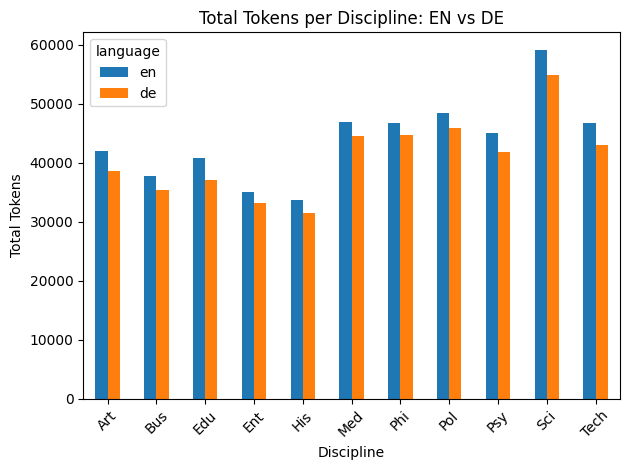

<Figure size 1200x600 with 0 Axes>

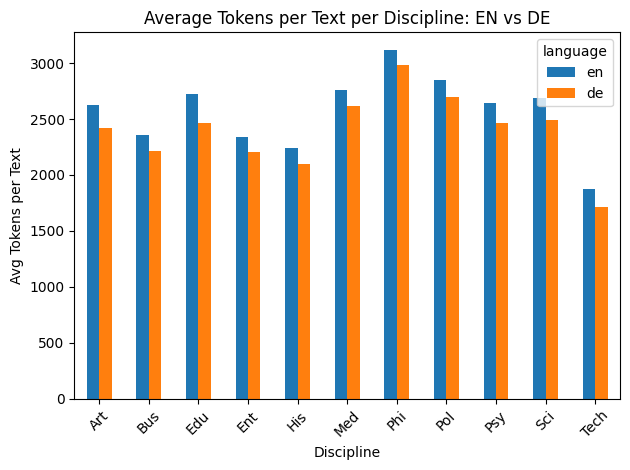

<Figure size 1200x600 with 0 Axes>

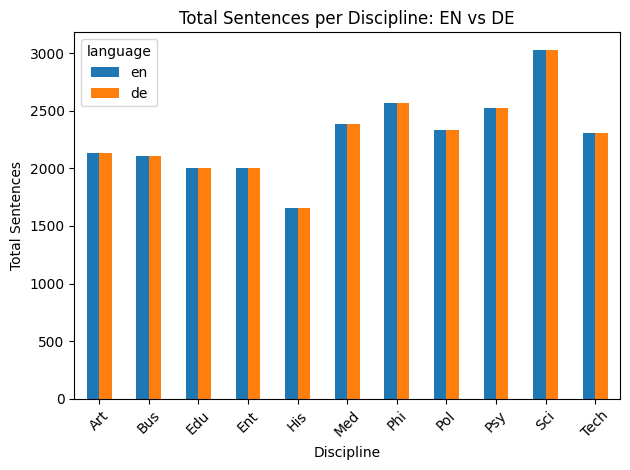

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- read CSV summary ---
csv_path = "conllu/conllu_folder_summary_stats_only.csv"  # adjust if needed
df = pd.read_csv(csv_path)

# --- extract language and discipline from folder path ---
# assuming folder path like: conllu/conllu_file/en/Bus
df['language'] = df['folder'].apply(lambda x: x.split(os.sep)[-2])
df['discipline'] = df['folder'].apply(lambda x: x.split(os.sep)[-1])

# --- pivot tables ---
tokens_pivot = df.pivot(index='discipline', columns='language', values='total_tokens')
avg_tokens_file_pivot = df.pivot(index='discipline', columns='language', values='avg_tokens_per_file')
sentences_pivot = df.pivot(index='discipline', columns='language', values='total_sentences')
avg_sent_file_pivot = df.pivot(index='discipline', columns='language', values='avg_sentences_per_file')

# --- ensure English before German for all pivots ---
def reorder_columns(pivot_df):
    desired_order = [lang for lang in ['en', 'de'] if lang in pivot_df.columns]
    return pivot_df[desired_order]

tokens_pivot = reorder_columns(tokens_pivot)
avg_tokens_file_pivot = reorder_columns(avg_tokens_file_pivot)
sentences_pivot = reorder_columns(sentences_pivot)
avg_sent_file_pivot = reorder_columns(avg_sent_file_pivot)

# --- sanity check ---
for name, pivot in {
    'tokens_pivot': tokens_pivot,
    'avg_tokens_file_pivot': avg_tokens_file_pivot,
    'sentences_pivot': sentences_pivot,
    'avg_sent_file_pivot': avg_sent_file_pivot,
}.items():
    for lang in ['en', 'de']:
        if lang not in pivot.columns:
            print(f"⚠️ Warning: '{lang}' missing in {name}")

# --- plot comparison ---
plt.figure(figsize=(12, 6))
tokens_pivot.plot(kind='bar', title='Total Tokens per Discipline: EN vs DE', rot=45)
plt.ylabel('Total Tokens')
plt.xlabel('Discipline')
plt.tight_layout()
plt.savefig('tokens_comparison.png')
plt.show()

plt.figure(figsize=(12, 6))
avg_tokens_file_pivot.plot(kind='bar', title='Average Tokens per Text per Discipline: EN vs DE', rot=45)
plt.ylabel('Avg Tokens per Text')
plt.xlabel('Discipline')
plt.tight_layout()
plt.savefig('avg_tokens_per_text_comparison.png')
plt.show()

plt.figure(figsize=(12, 6))
sentences_pivot.plot(kind='bar', title='Total Sentences per Discipline: EN vs DE', rot=45)
plt.ylabel('Total Sentences')
plt.xlabel('Discipline')
plt.tight_layout()
plt.savefig('sentences_comparison.png')
plt.show()


# Adding information to folder

In [13]:
def merge_folder_stats_only(folder_path, out_name=None, backup_existing=True):
    files = collect_conllu_files(folder_path)
    num_files = len(files)
    if num_files == 0:
        return None

    total_tokens = 0
    total_sentences = 0
    total_pairs = 0
    file_pairs = []  # NEW: keep per-file counts

    for fpath in files:
        with open(fpath, "r", encoding="utf-8") as fh:
            lines = fh.read().splitlines()
        t, s, p = conllu_stats_from_lines(lines)
        total_tokens += t
        total_sentences += s
        total_pairs += p
        file_pairs.append(p)

    avg_tokens_per_file = total_tokens / num_files if num_files else 0.0
    avg_sentences_per_file = total_sentences / num_files if num_files else 0.0
    avg_pairs_per_file = total_pairs / num_files if num_files else 0.0

    folder_name = os.path.basename(os.path.normpath(folder_path))
    if out_name is None:
        out_name = f"MERGED_{folder_name}.conllu"
    out_path = os.path.join(folder_path, out_name)

    header_lines = make_stats_block(
        total_tokens=total_tokens,
        avg_tokens_per_file=avg_tokens_per_file,
        total_sentences=total_sentences,
        avg_sentences_per_file=avg_sentences_per_file,
        total_pairs=total_pairs,
        avg_pairs_per_file=avg_pairs_per_file,
        num_files=num_files
    )

    with open(out_path, "w", encoding="utf-8", newline="\n") as f:
        f.write("\n".join(header_lines))

    return {
        "folder": folder_path,
        "out_path": out_path,
        "num_files": num_files,
        "total_tokens": total_tokens,
        "total_sentences": total_sentences,
        "total_pairs": total_pairs,
        "avg_tokens_per_file": avg_tokens_per_file,
        "avg_sentences_per_file": avg_sentences_per_file,
        "avg_pairs_per_file": avg_pairs_per_file,
        "file_pairs": file_pairs  # NEW
    }


# Adding different kind of graphs

In [22]:
#!/usr/bin/env python3
"""
Compute per-file and per-folder stats from a directory of .conllu files (punctuation-based sentences),
then produce multiple comparison plots (EN vs DE) and save CSV summaries.

Saves:
 - conllu_file_summary.csv
 - conllu_folder_summary_from_files.csv
 - All plots under ./plots/
"""
import os
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt

ROOT_DIR = "conllu"  # adjust if your root is elsewhere
SENT_END_PUNCT = {".", "!", "?"}


# ----------------- Data Processing -----------------
def conllu_stats_punc_from_lines(lines):
    """Return (tokens, sentences, pairs) based on punctuation detection in FORM (col 2)."""
    n_tokens, n_sentences = 0, 0
    for raw in lines:
        line = raw.strip()
        if not line or line.startswith("#"):
            continue
        cols = line.split("\t")
        if not cols:
            continue
        if "-" in cols[0]:  # skip multiword token lines
            continue
        if cols[0].isdigit():
            n_tokens += 1
            if len(cols) > 1 and cols[1] in SENT_END_PUNCT:
                n_sentences += 1
    n_pairs = max(0, n_sentences - 1)
    return n_tokens, n_sentences, n_pairs


def collect_conllu_files(root):
    """Return list of all .conllu/.conll files under root."""
    out = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            lower = fn.lower()
            if lower.endswith(".conllu") or lower.endswith(".conll"):
                if fn.startswith("MERGED_"):
                    continue
                out.append(os.path.join(dirpath, fn))
    return sorted(out)


def extract_lang_disc_from_path(path, root=ROOT_DIR):
    """Extract language and discipline from folder structure."""
    parts = os.path.normpath(path).split(os.sep)
    if root in parts:
        ridx = len(parts) - 1 - parts[::-1].index(root)
        tail = parts[ridx + 1 :]
    else:
        tail = parts[-3:] if len(parts) >= 3 else parts[:-1]
    if len(tail) >= 2:
        file_idx = len(parts) - 1
        discipline = parts[file_idx - 1] if file_idx - 1 >= 0 else "unknown"
        language = parts[file_idx - 2] if file_idx - 2 >= 0 else "unknown"
    else:
        language, discipline = "unknown", "unknown"
    return language, discipline


def compute_file_level_stats(root=ROOT_DIR):
    """Compute file-level statistics."""
    files = collect_conllu_files(root)
    rows = []
    for fpath in files:
        try:
            with open(fpath, "r", encoding="utf-8") as fh:
                lines = fh.read().splitlines()
        except Exception as e:
            print("Skipping file (read error):", fpath, e)
            continue
        tokens, sentences, pairs = conllu_stats_punc_from_lines(lines)
        lang, disc = extract_lang_disc_from_path(fpath, root)
        rows.append({
            "filepath": fpath,
            "filename": os.path.basename(fpath),
            "folder": os.path.dirname(fpath),
            "language": lang,
            "discipline": disc,
            "tokens": tokens,
            "sentences": sentences,
            "pairs": pairs,
            "tokens_per_sentence": (tokens / sentences) if sentences else float("nan")
        })
    df = pd.DataFrame(rows)
    if df.empty:
        print("No .conllu files found under", root)
    return df


def compute_folder_level_from_files(df_files):
    """Aggregate per-folder (discipline/language) statistics."""
    group = df_files.groupby(["language", "discipline"], sort=True)
    rows = []
    for (lang, disc), g in group:
        num_files = len(g)
        total_tokens = int(g["tokens"].sum())
        total_sentences = int(g["sentences"].sum())
        total_pairs = int(g["pairs"].sum())
        avg_tokens_per_file = float(g["tokens"].mean())
        avg_sentences_per_file = float(g["sentences"].mean())
        avg_pairs_per_file = float(g["pairs"].mean())
        avg_tokens_per_sentence = float(total_tokens / total_sentences) if total_sentences else float("nan")
        folder_path = os.path.join(ROOT_DIR, "conllu_file", lang, disc)
        rows.append({
            "folder": folder_path,
            "language": lang,
            "discipline": disc,
            "num_files": num_files,
            "total_tokens": total_tokens,
            "total_sentences": total_sentences,
            "total_pairs": total_pairs,
            "avg_tokens_per_file": avg_tokens_per_file,
            "avg_sentences_per_file": avg_sentences_per_file,
            "avg_pairs_per_file": avg_pairs_per_file,
            "avg_tokens_per_sentence": avg_tokens_per_sentence
        })
    df = pd.DataFrame(rows)
    df = df.sort_values(["discipline", "language"]).reset_index(drop=True)
    return df


# ----------------- Plot helpers -----------------
def make_plot_dir(subdir):
    path = os.path.join("plots", subdir)
    os.makedirs(path, exist_ok=True)
    return path


def reorder_en_before_de(pivot_df):
    """Ensure English comes before German in all plots."""
    desired_order = [lang for lang in ["en", "de"] if lang in pivot_df.columns]
    return pivot_df[desired_order]


def save_and_show(fig, filepath):
    fig.tight_layout()
    fig.savefig(filepath, dpi=150)
    print("Saved plot:", filepath)
    plt.close(fig)


def plot_folder_bar_comparison(df_folder, value_col, ylabel, title, subdir, filename):
    pivot = df_folder.pivot(index="discipline", columns="language", values=value_col)
    pivot = reorder_en_before_de(pivot)
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot.plot(kind="bar", ax=ax, rot=45)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Discipline")
    ax.set_title(title)
    save_and_show(fig, os.path.join(make_plot_dir(subdir), filename))


def plot_bubble(df_folder, subdir, filename="bubble_comparison.png"):
    fig, ax = plt.subplots(figsize=(10, 7))
    groups = df_folder.groupby("language")
    for lang, g in groups:
        x = g["avg_sentences_per_file"].values
        y = g["avg_tokens_per_file"].values
        sizes = (g["avg_tokens_per_sentence"].fillna(0).values) * 40
        labels = g["discipline"].values
        ax.scatter(x, y, s=sizes, label=lang)
        for xi, yi, lab in zip(x, y, labels):
            ax.text(xi, yi, lab, fontsize=8, alpha=0.8)
    ax.legend()
    ax.set_xlabel("Avg sentences per Text")
    ax.set_ylabel("Avg tokens per Text")
    ax.set_title("Bubble: avg_sentences/file vs avg_tokens/file (bubble ~ avg_tokens/sentence)")
    save_and_show(fig, os.path.join(make_plot_dir(subdir), filename))


def plot_boxplot_tokens_sentences(df_files, metric_col, subdir, filename):
    disciplines = sorted(df_files["discipline"].unique())
    languages = ["en", "de"]  # fixed order
    fig, ax = plt.subplots(figsize=(14, 6))

    colors = ["skyblue", "salmon"]
    lang_color_map = {lang: colors[i % len(colors)] for i, lang in enumerate(languages)}

    data, positions, box_colors = [], [], []
    pos = 1
    for disc in disciplines:
        for lang in languages:
            vals = df_files[(df_files["discipline"] == disc) & (df_files["language"] == lang)][metric_col].dropna().values
            if len(vals) == 0:
                vals = [0]
            data.append(vals)
            positions.append(pos)
            box_colors.append(lang_color_map[lang])
            pos += 1
        pos += 1

    bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
    for patch, color in zip(bp["boxes"], box_colors):
        patch.set_facecolor(color)

    ticks, tick_labels = [], []
    block_size = len(languages)
    for i, disc in enumerate(disciplines):
        center = (i * (block_size + 1)) + (block_size / 2.0) + 0.5
        ticks.append(center)
        tick_labels.append(disc)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=45)
    ax.set_title(f"Boxplots of {metric_col} per Text (EN vs DE)")
    ax.set_ylabel(metric_col)
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor=lang_color_map[lang]) for lang in languages]
    ax.legend(handles, languages, title="Language")
    save_and_show(fig, os.path.join(make_plot_dir(subdir), filename))


def plot_scatter_tokens_vs_sentences_per_discipline(df_files, subdir, prefix="scatter"):
    disciplines = sorted(df_files["discipline"].unique())
    for disc in disciplines:
        g = df_files[df_files["discipline"] == disc]
        if g.empty:
            continue
        fig, ax = plt.subplots(figsize=(8, 6))
        groups = g.groupby("language")
        for lang, sub in groups:
            ax.scatter(sub["sentences"], sub["tokens"], label=lang)
        ax.set_xlabel("Sentences (per Text)")
        ax.set_ylabel("Tokens (per Text)")
        ax.set_title(f"Tokens vs Sentences per Text — {disc}")
        ax.legend()
        save_and_show(fig, os.path.join(make_plot_dir(subdir), f"{prefix}_{disc}.png"))


def plot_histograms(df_files, metric_col, subdir, prefix):
    languages = ["en", "de"]
    for lang in languages:
        sub = df_files[df_files["language"] == lang]
        if sub.empty:
            continue
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.hist(sub[metric_col].dropna().values, bins=20)
        ax.set_xlabel(metric_col)
        ax.set_ylabel("Count")
        ax.set_title(f"Histogram of {metric_col} per Text — {lang}")
        save_and_show(fig, os.path.join(make_plot_dir(subdir), f"{prefix}_{lang}.png"))


# -------------------- Run pipeline --------------------
if __name__ == "__main__":
    df_files = compute_file_level_stats(ROOT_DIR)
    if df_files.empty:
        raise SystemExit("No files found. Check ROOT_DIR.")

    file_csv = "conllu_file_summary.csv"
    df_files.to_csv(file_csv, index=False)
    print("Wrote file-level summary:", file_csv)

    df_folder = compute_folder_level_from_files(df_files)
    folder_csv = "conllu_folder_summary_from_files.csv"
    df_folder.to_csv(folder_csv, index=False)
    print("Wrote folder-level summary:", folder_csv)

    # --- All Plots ---
    plot_folder_bar_comparison(df_folder, "total_tokens", "Total tokens", "Total tokens per discipline (EN vs DE)", "barplots", "folder_total_tokens.png")
    plot_folder_bar_comparison(df_folder, "total_sentences", "Total sentences", "Total sentences per discipline (EN vs DE)", "barplots", "folder_total_sentences.png")
    plot_folder_bar_comparison(df_folder, "avg_tokens_per_file", "Avg tokens per Text", "Average tokens per Text per discipline (EN vs DE)", "barplots", "folder_avg_tokens_per_file.png")
    plot_folder_bar_comparison(df_folder, "avg_sentences_per_file", "Avg sentences per Text", "Average sentences per Text per discipline (EN vs DE)", "barplots", "folder_avg_sentences_per_file.png")

    plot_bubble(df_folder, "bubbleplots", "folder_bubble_avg_sent_vs_tokens.png")

    plot_boxplot_tokens_sentences(df_files, "tokens", "boxplots", "boxplot_tokens_per_discipline.png")
    plot_boxplot_tokens_sentences(df_files, "sentences", "boxplots", "boxplot_sentences_per_discipline.png")
    plot_boxplot_tokens_sentences(df_files, "tokens_per_sentence", "boxplots", "boxplot_tokens_per_sentence.png")

    plot_scatter_tokens_vs_sentences_per_discipline(df_files, "scatterplots", "tokens_vs_sentences")
    plot_histograms(df_files, "tokens", "histograms", "hist_tokens")
    plot_histograms(df_files, "sentences", "histograms", "hist_sentences")

    print("\nAll plots generated under './plots/'")


Wrote file-level summary: conllu_file_summary.csv
Wrote folder-level summary: conllu_folder_summary_from_files.csv
Saved plot: plots/barplots/folder_total_tokens.png
Saved plot: plots/barplots/folder_total_sentences.png
Saved plot: plots/barplots/folder_avg_tokens_per_file.png
Saved plot: plots/barplots/folder_avg_sentences_per_file.png
Saved plot: plots/bubbleplots/folder_bubble_avg_sent_vs_tokens.png
Saved plot: plots/boxplots/boxplot_tokens_per_discipline.png
Saved plot: plots/boxplots/boxplot_sentences_per_discipline.png
Saved plot: plots/boxplots/boxplot_tokens_per_sentence.png
Saved plot: plots/scatterplots/tokens_vs_sentences_Art.png
Saved plot: plots/scatterplots/tokens_vs_sentences_Bus.png
Saved plot: plots/scatterplots/tokens_vs_sentences_Edu.png
Saved plot: plots/scatterplots/tokens_vs_sentences_Ent.png
Saved plot: plots/scatterplots/tokens_vs_sentences_His.png
Saved plot: plots/scatterplots/tokens_vs_sentences_Med.png
Saved plot: plots/scatterplots/tokens_vs_sentences_Phi.p

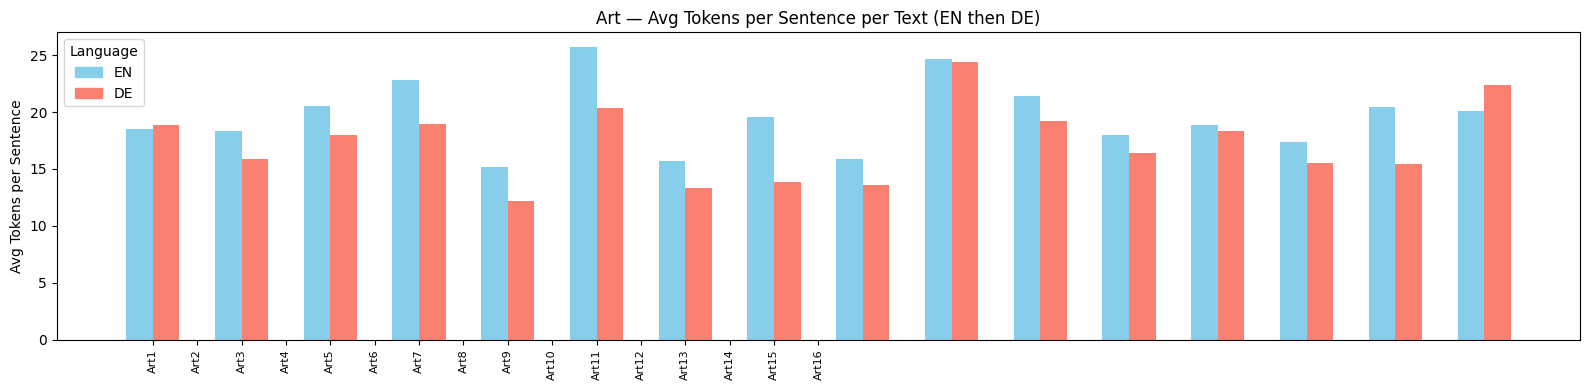

Saved: plots_tokens_per_sentence_per_file_grouped/Art_tokens_per_sentence_grouped.png


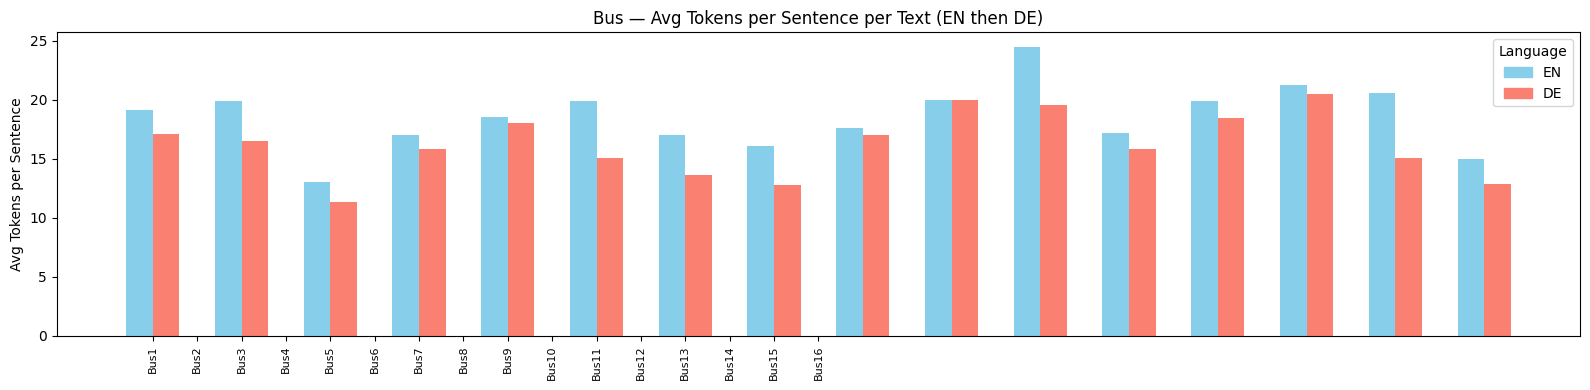

Saved: plots_tokens_per_sentence_per_file_grouped/Bus_tokens_per_sentence_grouped.png


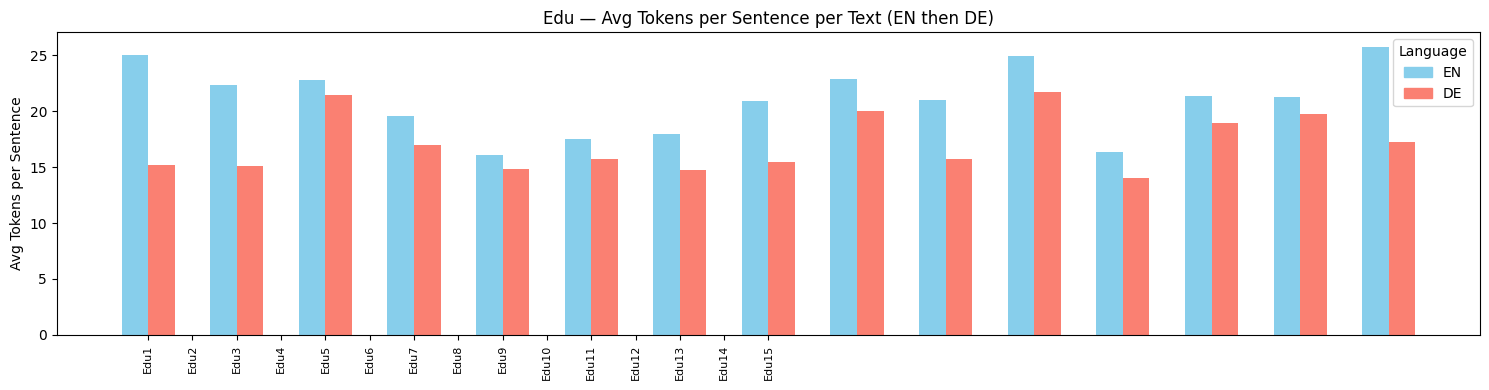

Saved: plots_tokens_per_sentence_per_file_grouped/Edu_tokens_per_sentence_grouped.png


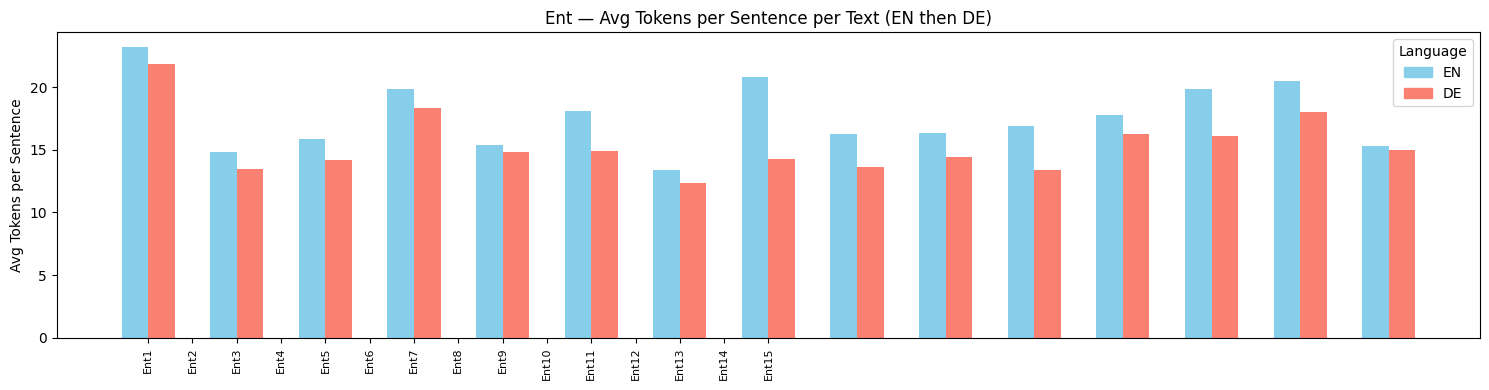

Saved: plots_tokens_per_sentence_per_file_grouped/Ent_tokens_per_sentence_grouped.png


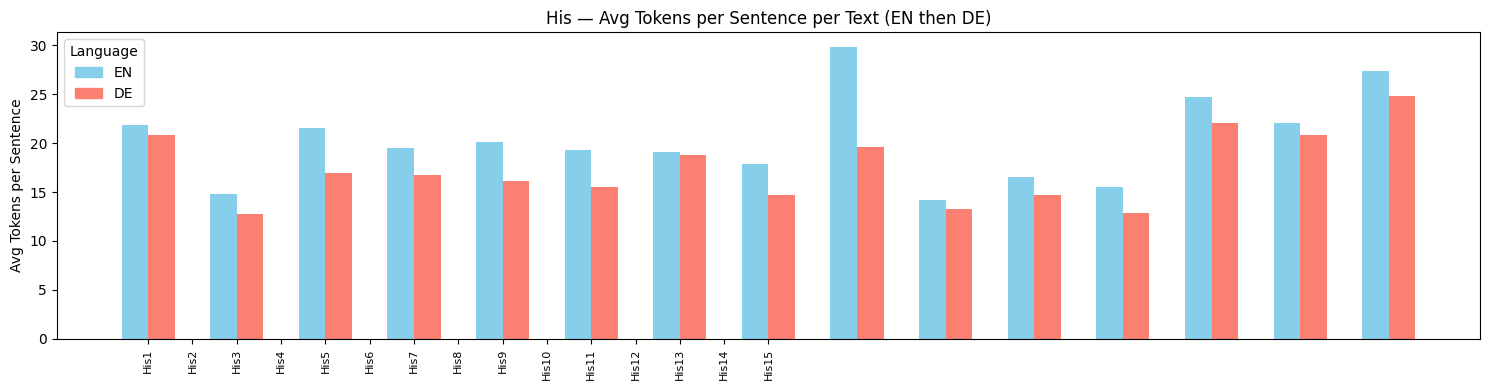

Saved: plots_tokens_per_sentence_per_file_grouped/His_tokens_per_sentence_grouped.png


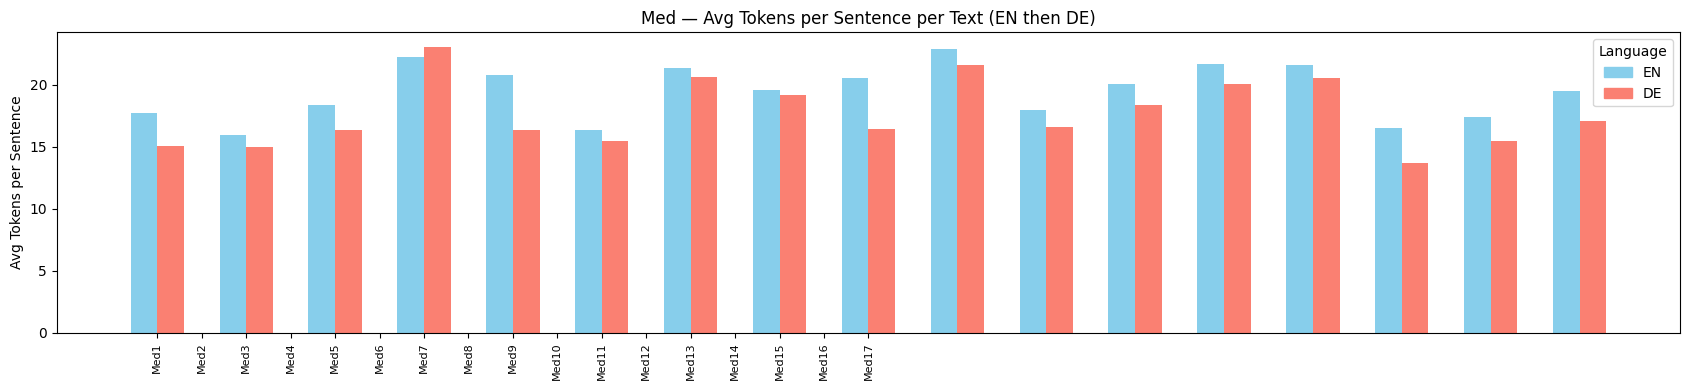

Saved: plots_tokens_per_sentence_per_file_grouped/Med_tokens_per_sentence_grouped.png


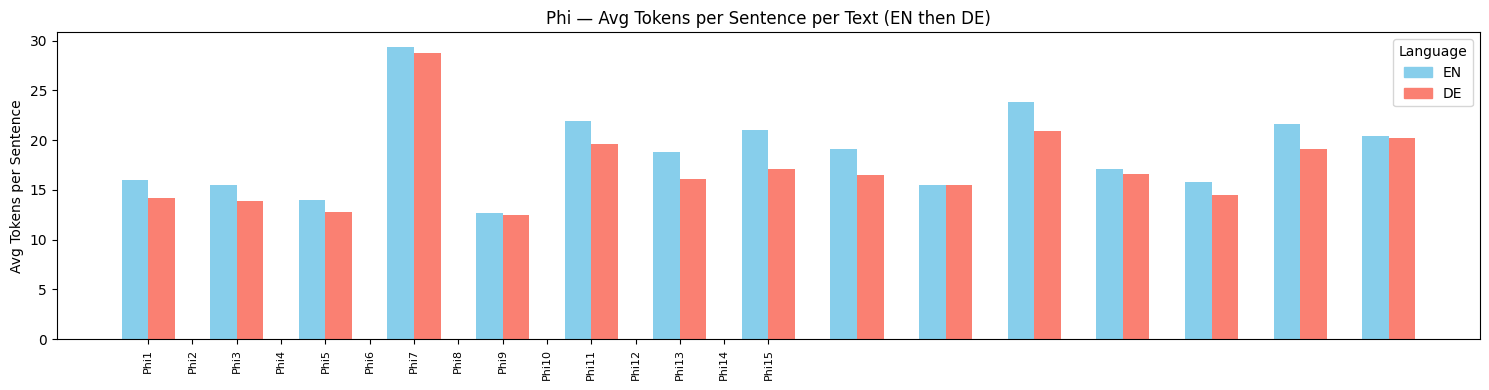

Saved: plots_tokens_per_sentence_per_file_grouped/Phi_tokens_per_sentence_grouped.png


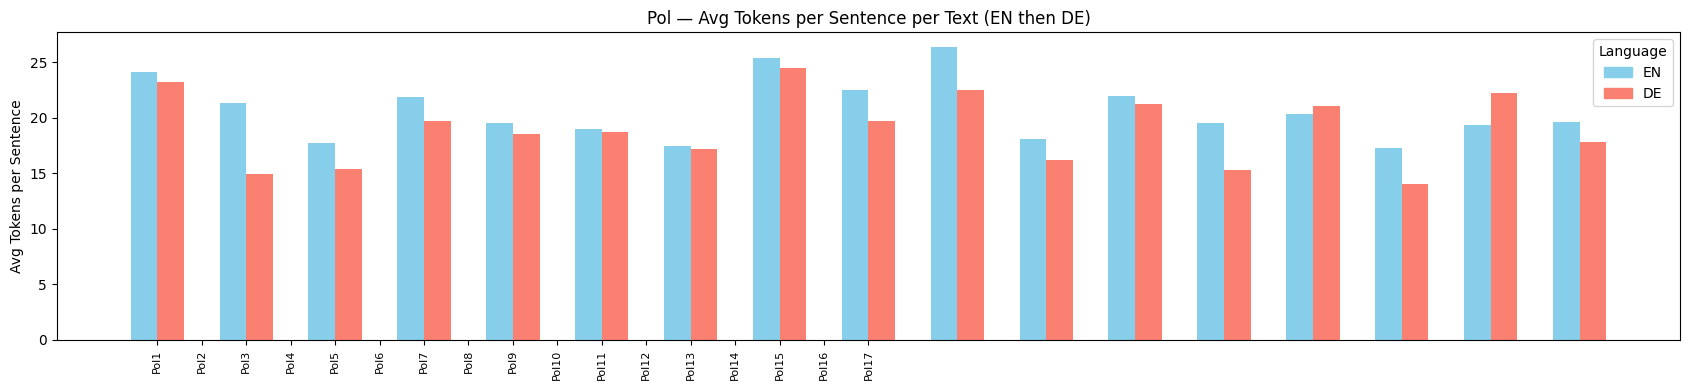

Saved: plots_tokens_per_sentence_per_file_grouped/Pol_tokens_per_sentence_grouped.png


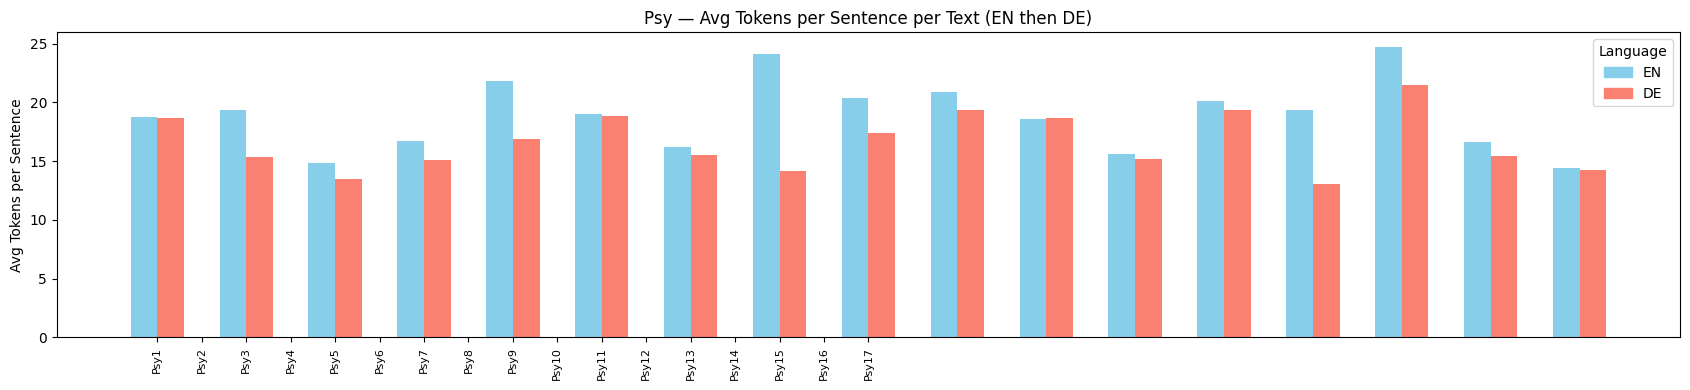

Saved: plots_tokens_per_sentence_per_file_grouped/Psy_tokens_per_sentence_grouped.png


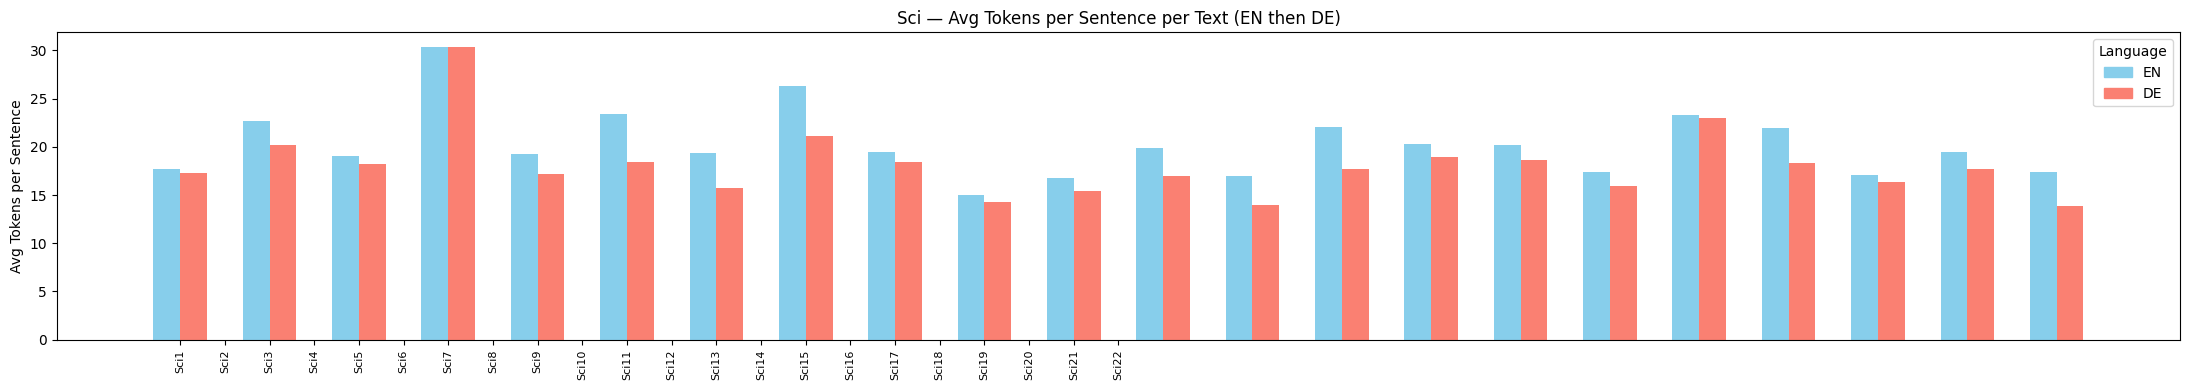

Saved: plots_tokens_per_sentence_per_file_grouped/Sci_tokens_per_sentence_grouped.png


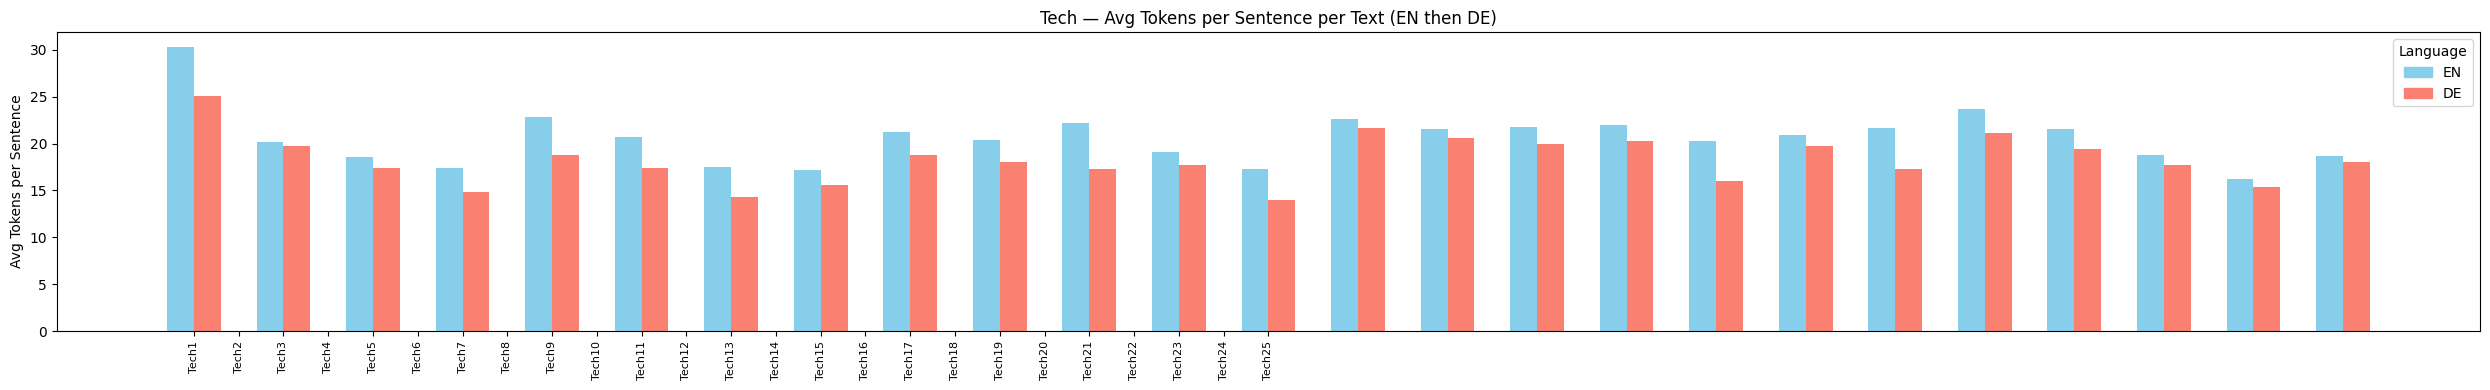

Saved: plots_tokens_per_sentence_per_file_grouped/Tech_tokens_per_sentence_grouped.png


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# Function for natural sort key
def natural_sort_key(s):
    """Split numbers and text for natural sorting (e.g., file2 before file10)."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r"(\d+)", s)]

# Load per-file summary
df = pd.read_csv("conllu_file_summary.csv")
df["language"] = df["language"].str.lower().str.strip()
df["discipline"] = df["discipline"].str.strip()
df["file_base"] = df["filepath"].apply(lambda x: os.path.basename(x))

# Compute tokens per sentence
df["tokens_per_sentence"] = df["tokens"] / df["sentences"]

# Create output folder
out_dir = "plots_tokens_per_sentence_per_file_grouped"
os.makedirs(out_dir, exist_ok=True)

for disc in sorted(df["discipline"].unique()):
    sub = df[df["discipline"] == disc].copy()
    if sub.empty:
        continue

    # Split EN and DE
    en_rows = sub[sub["language"] == "en"]
    de_rows = sub[sub["language"] == "de"]

    # Sort files naturally
    en_rows = en_rows.sort_values("file_base", key=lambda x: x.map(natural_sort_key))
    de_rows = de_rows.sort_values("file_base", key=lambda x: x.map(natural_sort_key))

    # Align by position (zip stops at shortest)
    plot_rows = []
    for en, de in zip(en_rows.iterrows(), de_rows.iterrows()):
        plot_rows.append(en[1])
        plot_rows.append(de[1])

    plot_df = pd.DataFrame(plot_rows)

    # X positions: EN first, then DE
    n_files = len(plot_df) // 2
    x = []
    for i in range(n_files):
        x.append(i * 2)         # EN
        x.append(i * 2 + 0.6)   # DE (shifted right)
    x = np.array(x)

    # Colors: EN = blue, DE = red
    colors = ["skyblue" if l == "en" else "salmon" for l in plot_df["language"]]

    # Plot
    fig, ax = plt.subplots(figsize=(max(6, n_files), 4))
    ax.bar(x, plot_df["tokens_per_sentence"], color=colors, width=0.6)

    # Center x-ticks between each EN–DE pair
    xticks = [i + 0.3 for i in range(n_files)]
    xtick_labels = [
        re.sub(r"_(en|de)\.conllu$", "", fb)
        for fb in plot_df["file_base"].iloc[::2]
    ]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=90, fontsize=8)

    ax.set_ylabel("Avg Tokens per Sentence")
    ax.set_title(f"{disc} — Avg Tokens per Sentence per Text (EN then DE)")

    # Legend (EN = blue, DE = red)
    handles = [
        plt.Rectangle((0, 0), 1, 1, color="skyblue"),
        plt.Rectangle((0, 0), 1, 1, color="salmon"),
    ]
    ax.legend(handles, ["EN", "DE"], title="Language")

    plt.tight_layout()
    out_path = os.path.join(out_dir, f"{disc}_tokens_per_sentence_grouped.png")
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)


# Adjective Analysis

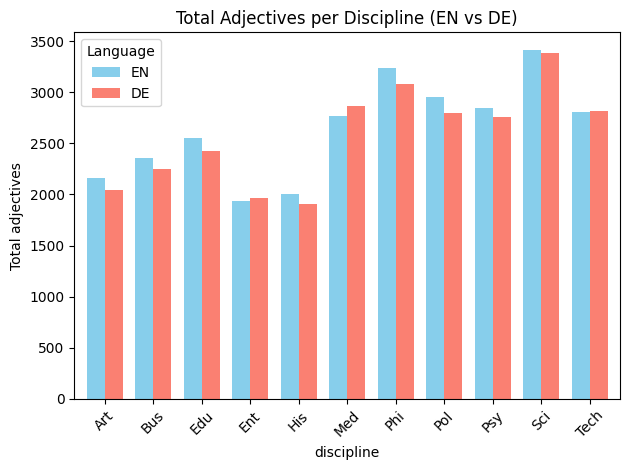

Saved: plots_adjectives/total_adjectives.png


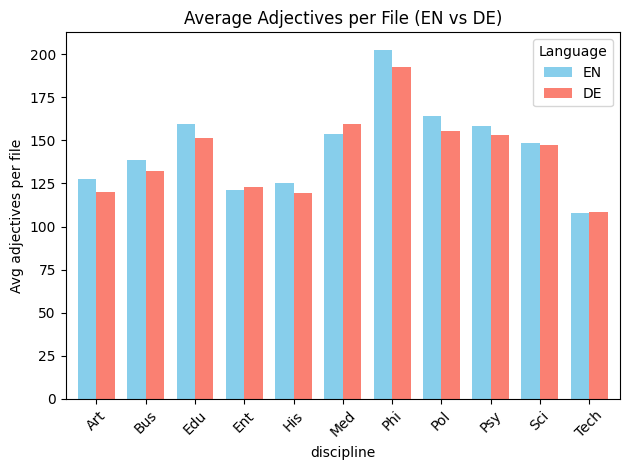

Saved: plots_adjectives/avg_adj_per_file.png


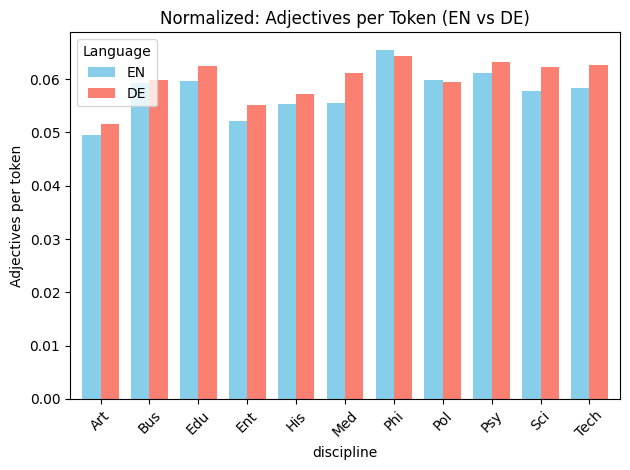

Saved: plots_adjectives/adj_per_token.png


In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def conllu_token_stats(path):
    """Return (tokens, sentences, adjectives) for a file."""
    n_tokens, n_sentences, n_adj = 0, 0, 0
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            parts = line.split("\t")
            if len(parts) > 3:
                # token id check (skip multiword 1-2 ranges)
                if "-" in parts[0]:
                    continue
                n_tokens += 1
                upos = parts[3]
                if upos == "ADJ":
                    n_adj += 1
            elif line.startswith("# sent_id"):
                n_sentences += 1
    return n_tokens, n_sentences, n_adj


def collect_adj_stats(root="conllu/conllu_file"):
    rows = []
    for dirpath, _, files in os.walk(root):
        for fname in files:
            if fname.endswith(".conllu"):
                path = os.path.join(dirpath, fname)
                tokens, sentences, adjs = conllu_token_stats(path)
                rows.append({
                    "filepath": path,
                    "file": fname,
                    "discipline": os.path.basename(os.path.dirname(path)),
                    "language": os.path.basename(os.path.dirname(os.path.dirname(path))),
                    "tokens": tokens,
                    "sentences": sentences,
                    "adjectives": adjs,
                    "adj_per_token": adjs / tokens if tokens else 0,
                    "adj_per_sentence": adjs / sentences if sentences else 0
                })
    return pd.DataFrame(rows)


# --- Run collection
df_adj = collect_adj_stats("conllu/conllu_file")
df_adj.to_csv("conllu/adjective_stats_per_file.csv", index=False)

# --- Discipline-level summary
summary = df_adj.groupby(["language", "discipline"]).agg(
    files=("file", "count"),
    total_tokens=("tokens", "sum"),
    total_sentences=("sentences", "sum"),
    total_adjectives=("adjectives", "sum"),
    avg_adj_per_file=("adjectives", "mean"),
    avg_adj_per_token=("adj_per_token", "mean"),
    avg_adj_per_sentence=("adj_per_sentence", "mean")
).reset_index()

summary.to_csv("conllu/adjective_summary_per_discipline.csv", index=False)

# --- PLOTS ---
outdir = "plots_adjectives"
os.makedirs(outdir, exist_ok=True)

def plot_bar(df, metric, ylabel, title, fname):
    pivot = df.pivot(index="discipline", columns="language", values=metric)

    # Ensure EN first, DE second
    lang_order = [lang for lang in ["en", "de"] if lang in pivot.columns]
    pivot = pivot[lang_order]

    # Custom color order
    color_map = {"en": "skyblue", "de": "salmon"}
    colors = [color_map[lang] for lang in lang_order]

    # Plot with custom colors
    ax = pivot.plot(kind="bar", color=colors, width=0.75)

    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title="Language", labels=[lang.upper() for lang in lang_order])
    plt.tight_layout()

    save_path = os.path.join(outdir, fname)
    plt.savefig(save_path, dpi=150)
    plt.show()
    print("Saved:", save_path)


# --- Generate all plots ---
plot_bar(summary, "total_adjectives", "Total adjectives",
         "Total Adjectives per Discipline (EN vs DE)", "total_adjectives.png")

plot_bar(summary, "avg_adj_per_file", "Avg adjectives per file",
         "Average Adjectives per File (EN vs DE)", "avg_adj_per_file.png")

plot_bar(summary, "avg_adj_per_token", "Adjectives per token",
         "Normalized: Adjectives per Token (EN vs DE)", "adj_per_token.png")



CSV saved to: conllu/top10_adjectives_per_folder.csv


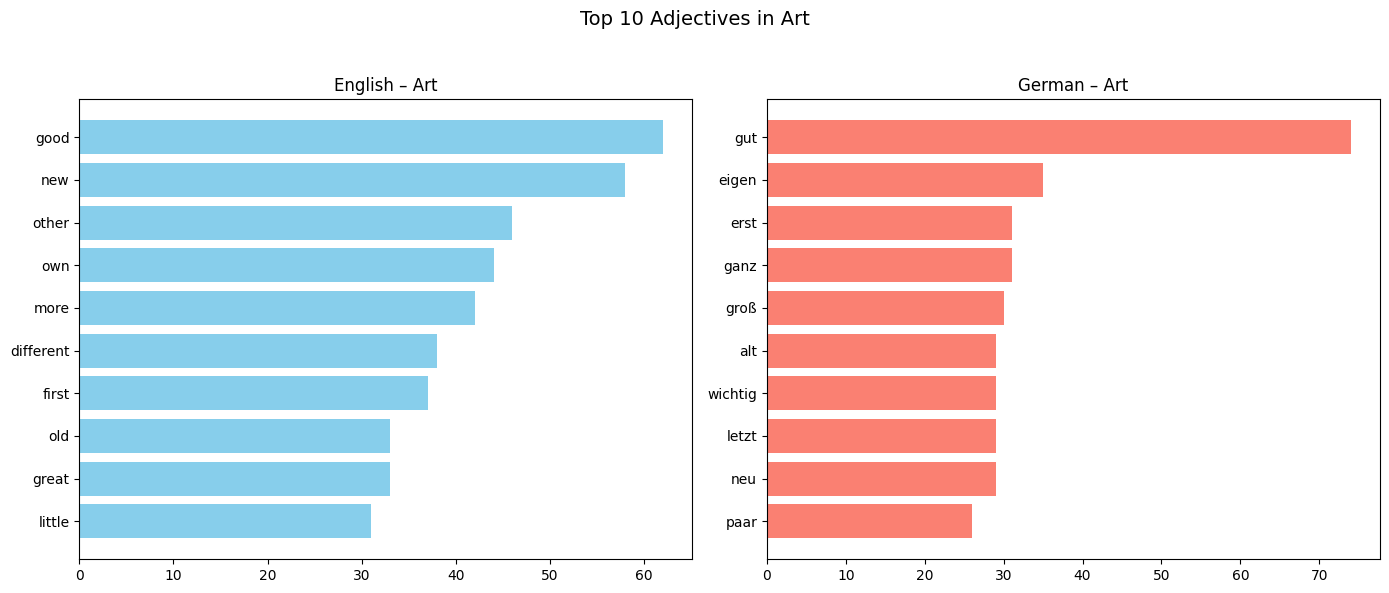

Saved: plots_adjectives/Art_top10_adjectives.png


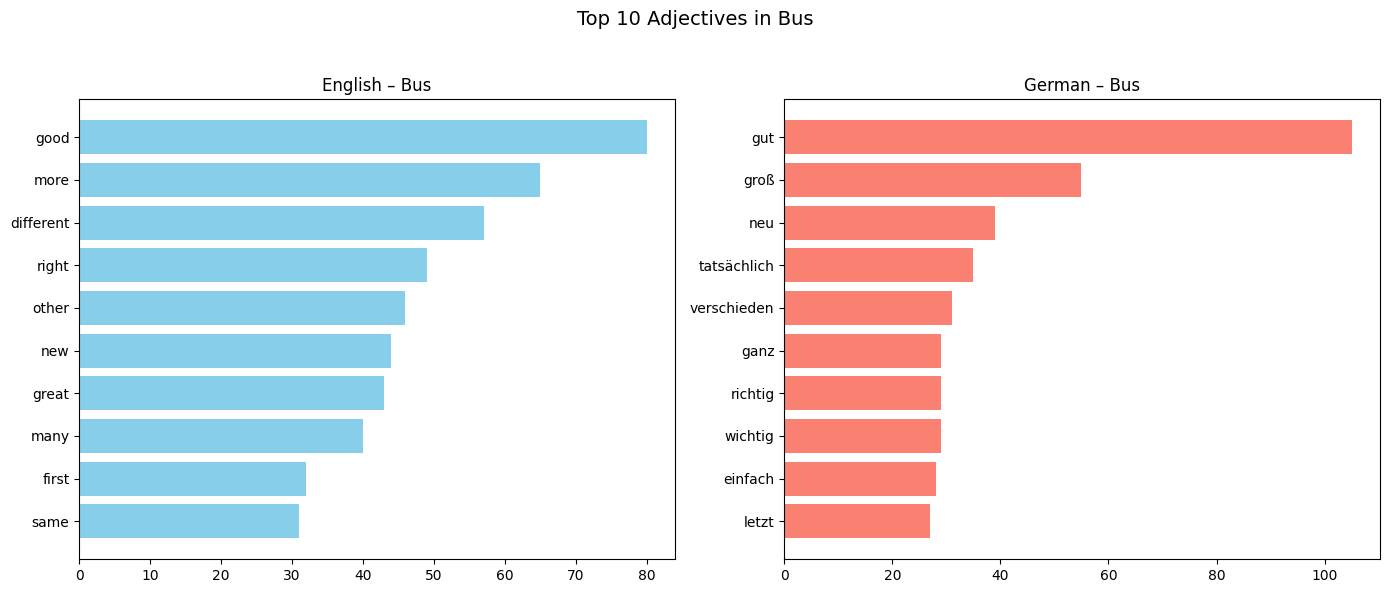

Saved: plots_adjectives/Bus_top10_adjectives.png


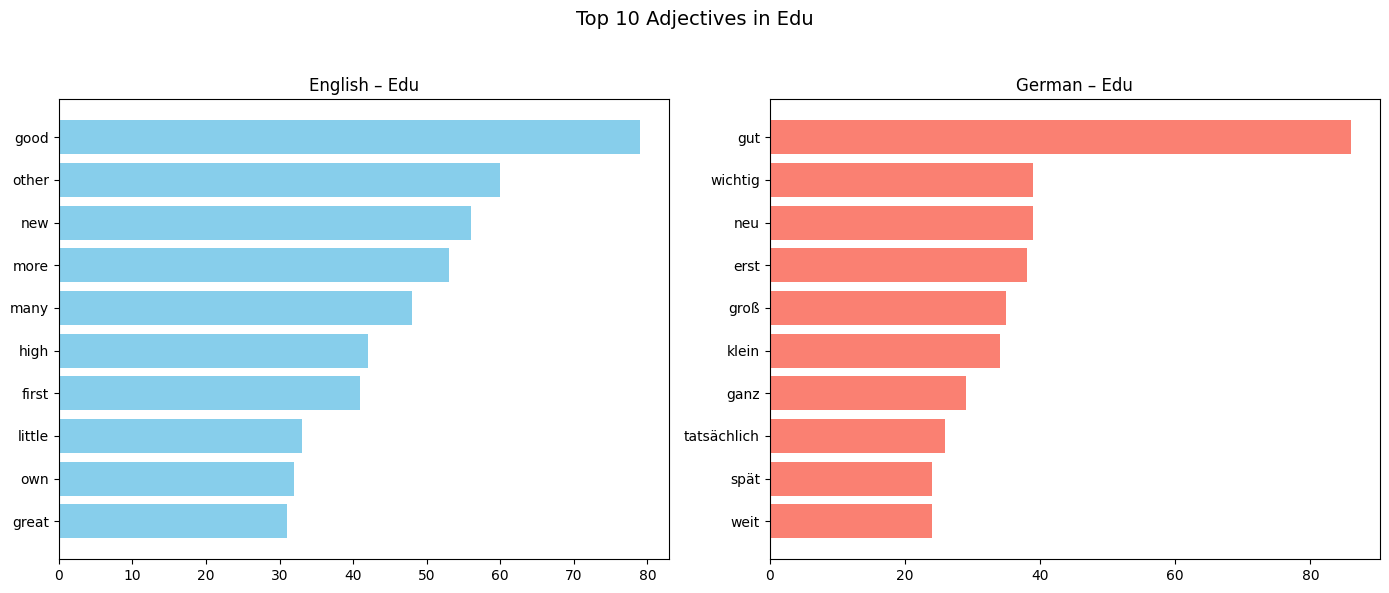

Saved: plots_adjectives/Edu_top10_adjectives.png


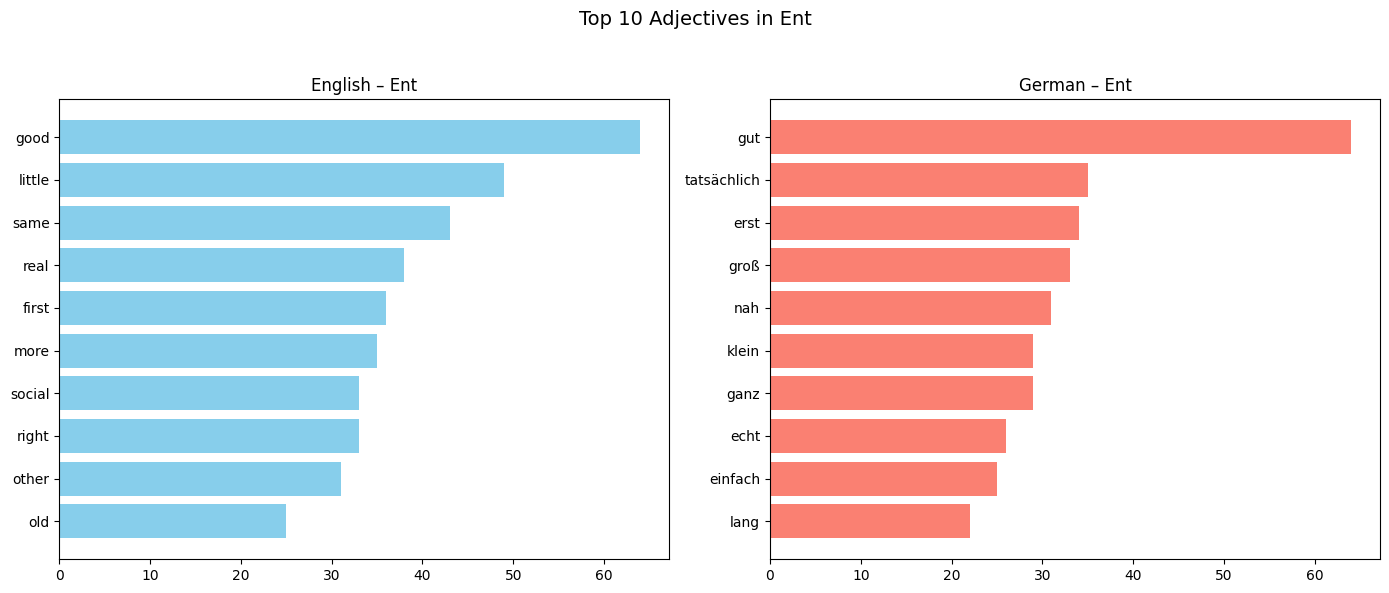

Saved: plots_adjectives/Ent_top10_adjectives.png


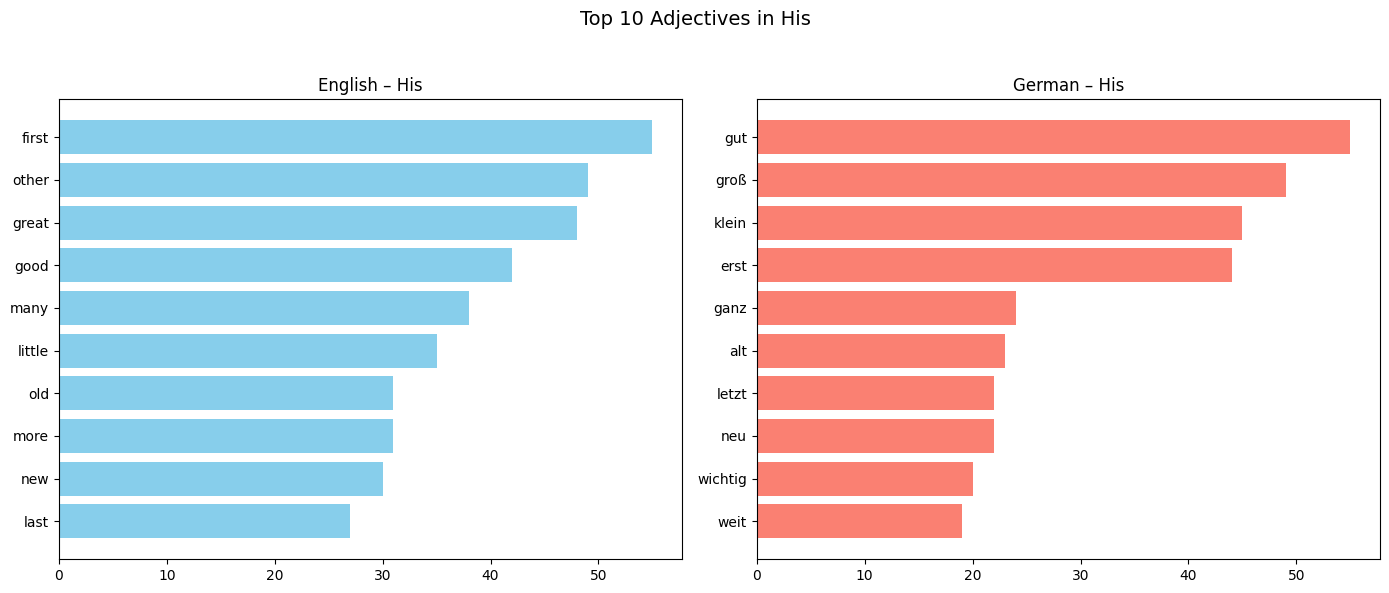

Saved: plots_adjectives/His_top10_adjectives.png


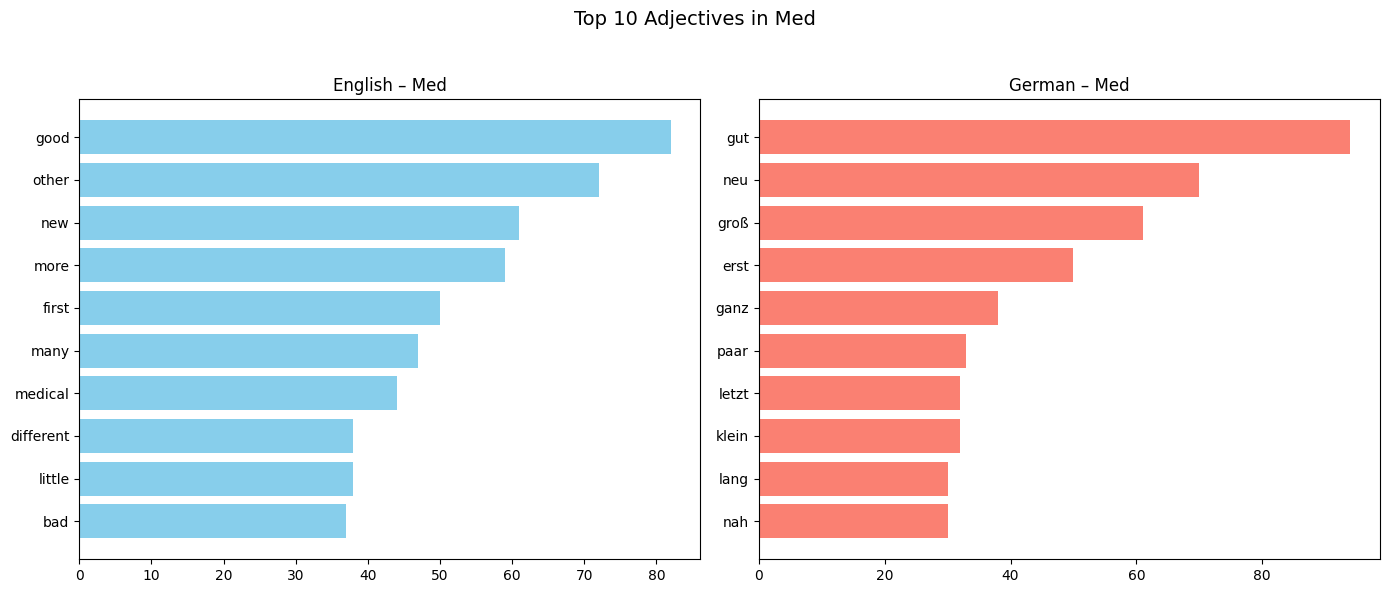

Saved: plots_adjectives/Med_top10_adjectives.png


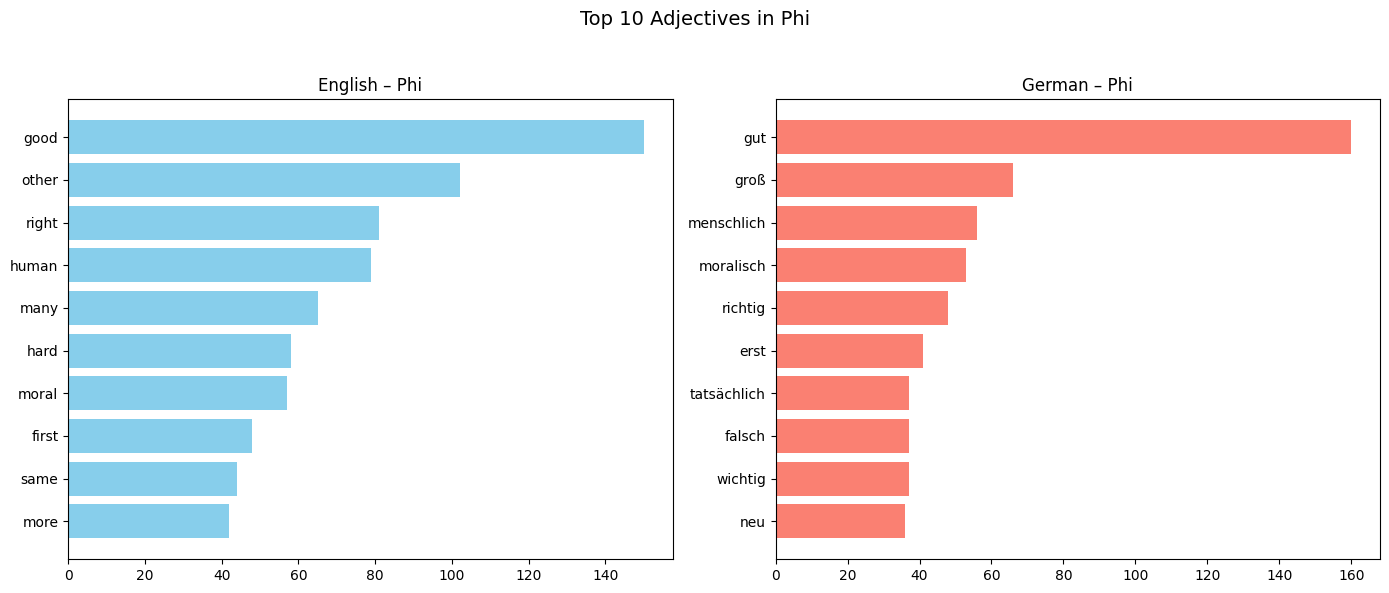

Saved: plots_adjectives/Phi_top10_adjectives.png


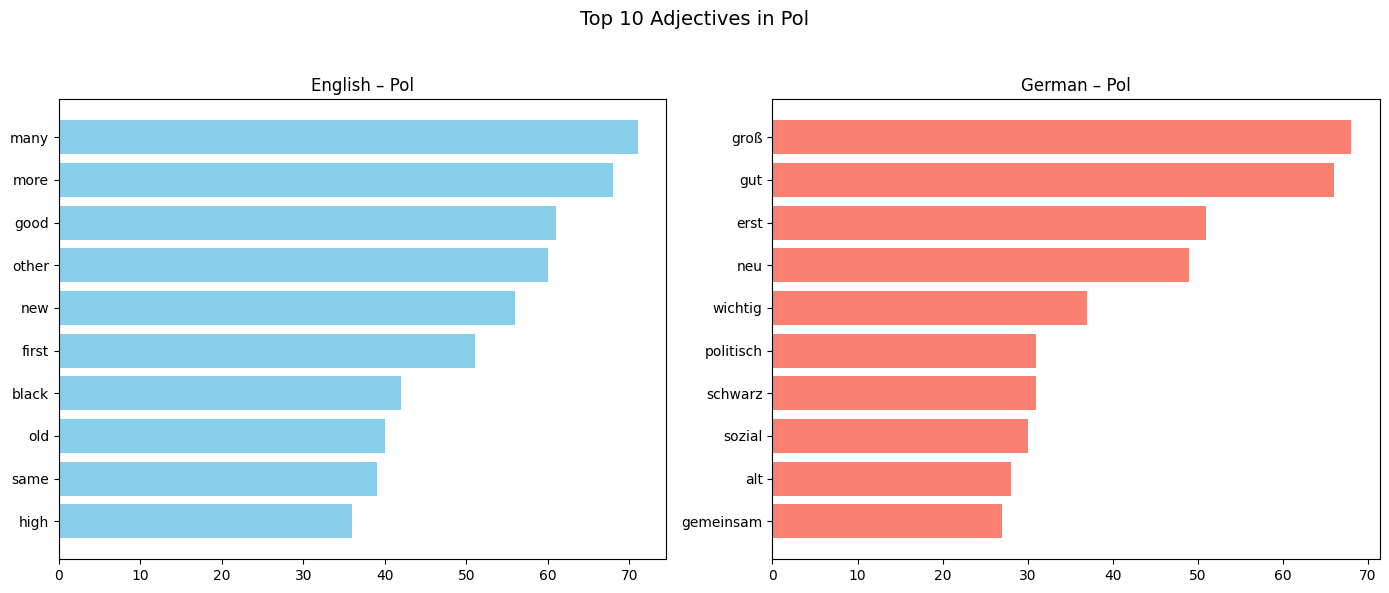

Saved: plots_adjectives/Pol_top10_adjectives.png


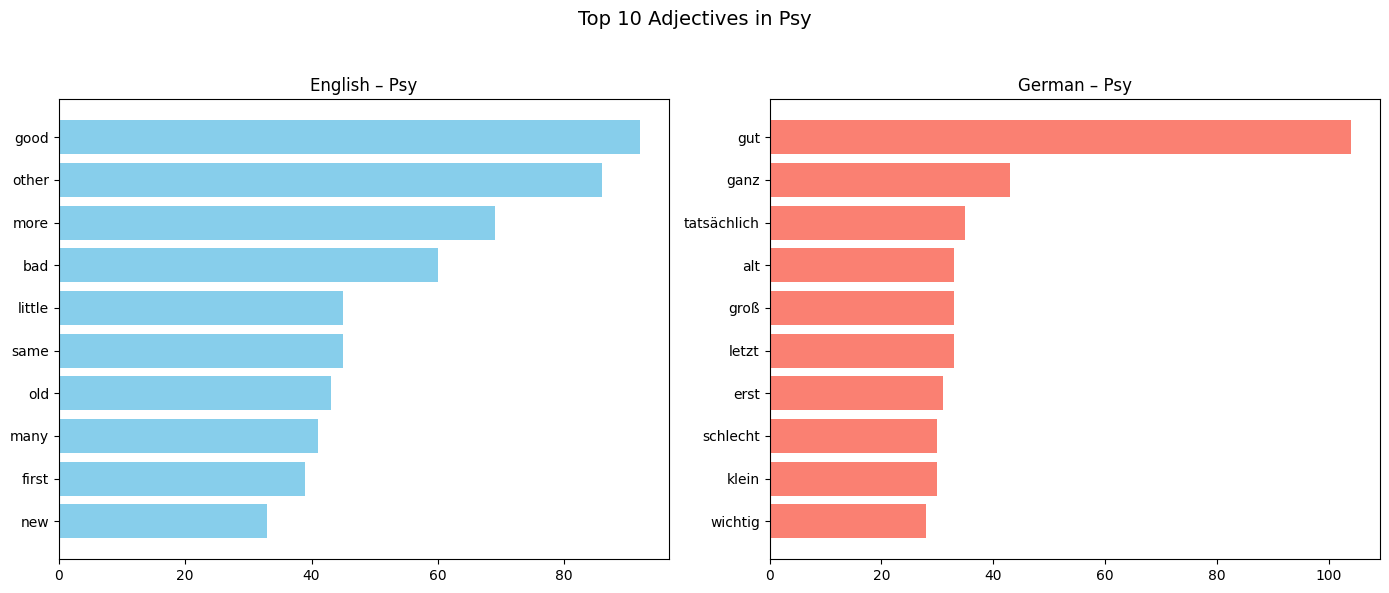

Saved: plots_adjectives/Psy_top10_adjectives.png


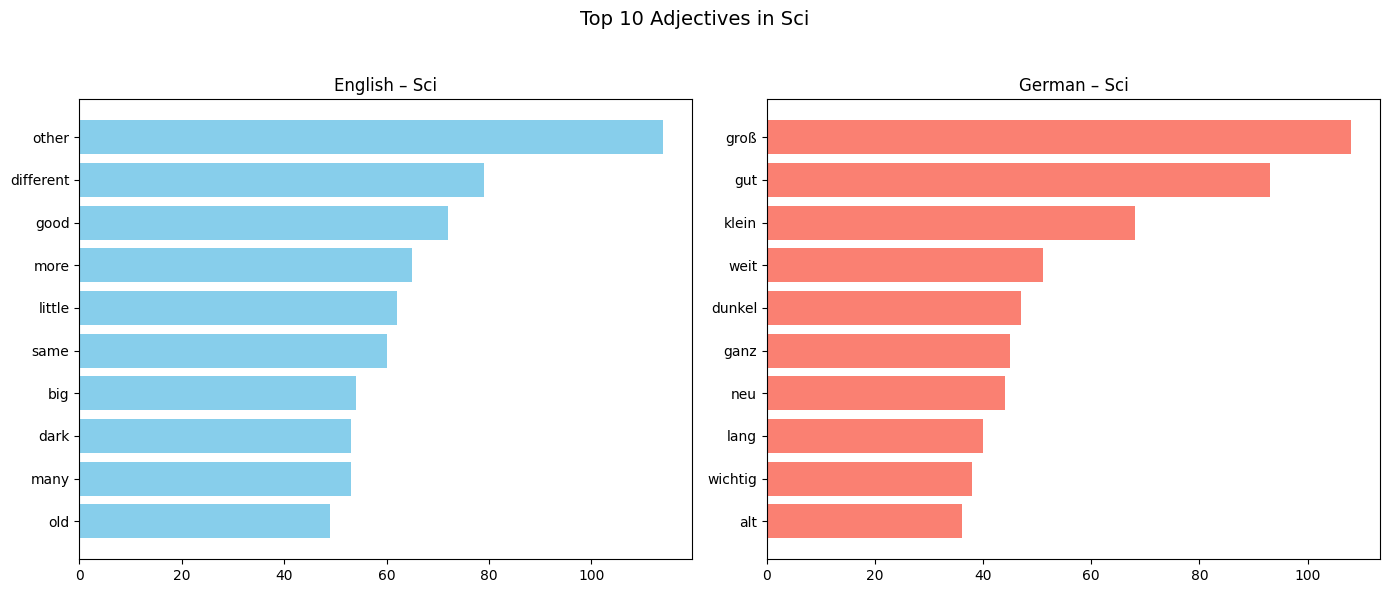

Saved: plots_adjectives/Sci_top10_adjectives.png


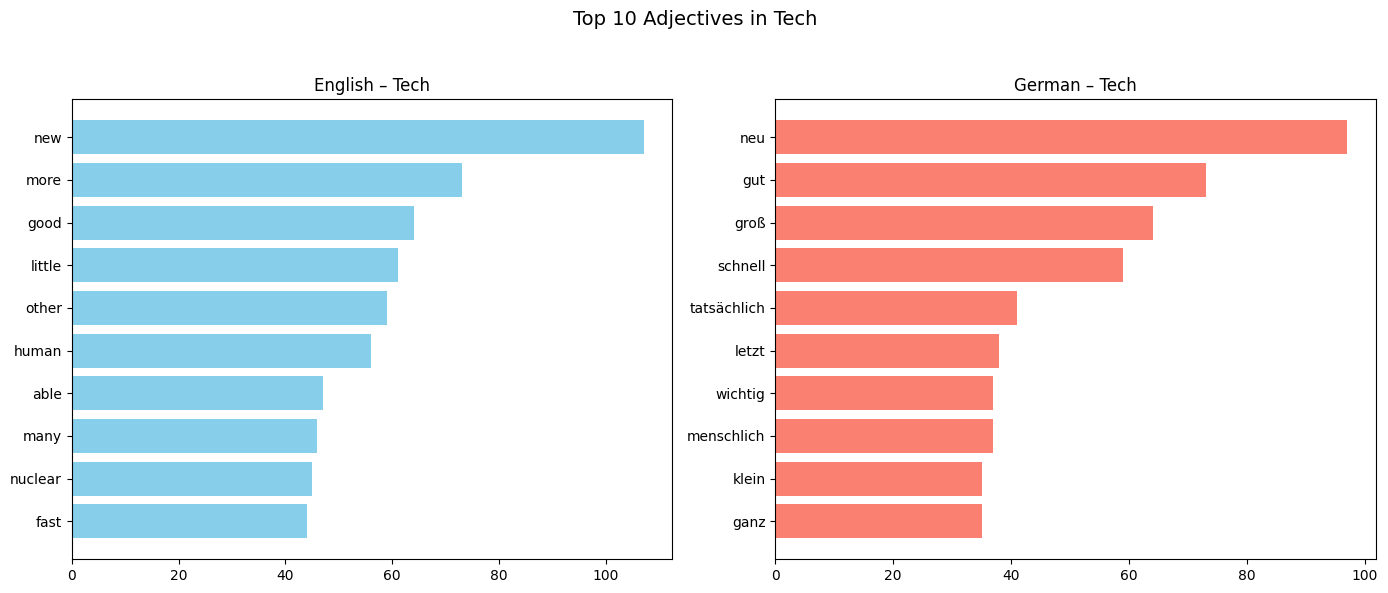

Saved: plots_adjectives/Tech_top10_adjectives.png


In [29]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

def top_adjectives_per_folder(root="conllu/conllu_file", top_n=10):
    results = []
    for lang in os.listdir(root):
        lang_path = os.path.join(root, lang)
        if not os.path.isdir(lang_path):
            continue
        for discipline in os.listdir(lang_path):
            disc_path = os.path.join(lang_path, discipline)
            if not os.path.isdir(disc_path):
                continue

            adj_counter = Counter()

            for fname in os.listdir(disc_path):
                if not fname.endswith(".conllu"):
                    continue
                path = os.path.join(disc_path, fname)

                with open(path, "r", encoding="utf-8") as f:
                    for line in f:
                        if not line.strip() or line.startswith("#"):
                            continue
                        parts = line.split("\t")
                        if len(parts) > 3 and parts[3] == "ADJ":
                            lemma = parts[2] if parts[2] != "_" else parts[1]
                            adj_counter[lemma.lower()] += 1

            for word, freq in adj_counter.most_common(top_n):
                results.append({
                    "language": lang.lower(),
                    "discipline": discipline,
                    "adjective": word,
                    "count": freq
                })
    return pd.DataFrame(results)


# --- Run
df_top_adj = top_adjectives_per_folder("conllu/conllu_file", top_n=10)

# Save results
df_top_adj.to_csv("conllu/top10_adjectives_per_folder.csv", index=False)
print("CSV saved to: conllu/top10_adjectives_per_folder.csv")

# --- Plot side-by-side comparison (EN left, DE right)
disciplines = sorted(df_top_adj["discipline"].unique())

outdir = "plots_adjectives"
os.makedirs(outdir, exist_ok=True)

for disc in disciplines:
    subset = df_top_adj[df_top_adj["discipline"] == disc]

    en = subset[subset["language"] == "en"].sort_values("count", ascending=False).head(10)
    de = subset[subset["language"] == "de"].sort_values("count", ascending=False).head(10)

    # Skip if one language missing
    if en.empty and de.empty:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- English (Left) ---
    if not en.empty:
        axes[0].barh(en["adjective"], en["count"], color="skyblue")
        axes[0].set_title(f"English – {disc}", fontsize=12)
        axes[0].invert_yaxis()
    else:
        axes[0].text(0.5, 0.5, "No English data", ha="center", va="center", fontsize=12)
        axes[0].axis("off")

    # --- German (Right) ---
    if not de.empty:
        axes[1].barh(de["adjective"], de["count"], color="salmon")
        axes[1].set_title(f"German – {disc}", fontsize=12)
        axes[1].invert_yaxis()
    else:
        axes[1].text(0.5, 0.5, "No German data", ha="center", va="center", fontsize=12)
        axes[1].axis("off")

    plt.suptitle(f"Top 10 Adjectives in {disc}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save figure
    out_path = os.path.join(outdir, f"{disc}_top10_adjectives.png")
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Saved: {out_path}")


In [34]:
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "conllu/conllu_file"   # change if your tree is elsewhere
TOP_N = 20
OUT_DIR = "plots_adjectives"
os.makedirs(OUT_DIR, exist_ok=True)

def collect_adj_counts(root):
    """Walk root/lang/discipline/*.conllu and count adjectives by lemma (fallback to FORM)."""
    overall = Counter()
    by_language = {}  # language -> Counter
    by_discipline = {}  # (language, discipline) -> Counter  (optional)

    for lang in os.listdir(root):
        lang_path = os.path.join(root, lang)
        if not os.path.isdir(lang_path):
            continue
        lang_lower = lang.lower()
        if lang_lower not in by_language:
            by_language[lang_lower] = Counter()

        for disc in os.listdir(lang_path):
            disc_path = os.path.join(lang_path, disc)
            if not os.path.isdir(disc_path):
                continue

            key = (lang_lower, disc)
            by_discipline.setdefault(key, Counter())

            for fname in os.listdir(disc_path):
                if not fname.lower().endswith(".conllu"):
                    continue
                fpath = os.path.join(disc_path, fname)
                try:
                    with open(fpath, "r", encoding="utf-8") as fh:
                        for line in fh:
                            if not line.strip() or line.startswith("#"):
                                continue
                            parts = line.rstrip("\n").split("\t")
                            # ensure we have UPOS column (index 3)
                            if len(parts) > 3 and parts[3] == "ADJ":
                                lemma = parts[2] if parts[2] != "_" else parts[1]
                                token = lemma.strip().lower()
                                if token == "":
                                    continue
                                overall[token] += 1
                                by_language[lang_lower][token] += 1
                                by_discipline[key][token] += 1
                except Exception as e:
                    print("Warning: failed to read", fpath, e)
    return overall, by_language, by_discipline

def counter_to_df(counter, language=None, discipline=None):
    rows = []
    for word, cnt in counter.most_common():
        rows.append({"language": language if language is not None else "all",
                     "discipline": discipline if discipline is not None else "",
                     "adjective": word, "count": cnt})
    return pd.DataFrame(rows)

def save_top_csv_and_plot(counter, title, csv_path, png_path, top_n=20, color="tab:skyblue"):
    top = counter.most_common(top_n)
    df = pd.DataFrame(top, columns=["adjective", "count"])
    df.to_csv(csv_path, index=False)
    # plot horizontal bar
    plt.figure(figsize=(8, max(4, 0.25*len(df))))
    plt.barh(df["adjective"][::-1], df["count"][::-1], color=color)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    plt.close()
    print("Saved:", csv_path, "and", png_path)

if __name__ == "__main__":
    overall, by_lang, by_disc = collect_adj_counts(ROOT)

    # Top 20 overall
    save_top_csv_and_plot(
        overall,
        title=f"Top {TOP_N} Adjectives — Overall",
        csv_path=os.path.join(OUT_DIR, f"top{TOP_N}_adjectives_overall.csv"),
        png_path=os.path.join(OUT_DIR, f"top{TOP_N}_adjectives_overall.png"),
        top_n=TOP_N,
        color="purple"
    )

    # Ensure English comes first
    languages = list(by_lang.keys())
    if "en" in languages:
        languages.remove("en")
        languages = ["en"] + languages

    per_lang_rows = []
    for lang in languages:
        counter = by_lang[lang]
        csv_path = os.path.join(OUT_DIR, f"top{TOP_N}_adjectives_{lang}.csv")
        png_path = os.path.join(OUT_DIR, f"top{TOP_N}_adjectives_{lang}.png")

        # Color scheme: EN = skyblue, DE = salmon, others = grey
        if lang == "en":
            color = "skyblue"
        elif lang == "de":
            color = "salmon"
        else:
            color = "grey"

        save_top_csv_and_plot(
            counter,
            title=f"Top {TOP_N} Adjectives — {lang.upper()}",
            csv_path=csv_path,
            png_path=png_path,
            top_n=TOP_N,
            color=color
        )

        # Collect for combined CSV
        df_lang = counter_to_df(counter, language=lang).head(TOP_N)
        per_lang_rows.append(df_lang)

    # Combine per-language top lists into one CSV
    if per_lang_rows:
        combined = pd.concat(per_lang_rows, ignore_index=True)
        combined.to_csv(os.path.join(OUT_DIR, f"top{TOP_N}_adjectives_per_language_combined.csv"), index=False)
        print("Saved combined per-language CSV.")

    # Top adjectives per discipline
    for (lang, disc), counter in sorted(by_disc.items()):
        out_csv = os.path.join(OUT_DIR, f"top{TOP_N}_adjectives_{lang}_{disc}.csv")
        df_disc = counter_to_df(counter, language=lang, discipline=disc).head(TOP_N)
        df_disc.to_csv(out_csv, index=False)

    print("Done. Results in folder:", OUT_DIR)


Saved: plots_adjectives/top20_adjectives_overall.csv and plots_adjectives/top20_adjectives_overall.png
Saved: plots_adjectives/top20_adjectives_en.csv and plots_adjectives/top20_adjectives_en.png
Saved: plots_adjectives/top20_adjectives_de.csv and plots_adjectives/top20_adjectives_de.png
Saved combined per-language CSV.
Done. Results in folder: plots_adjectives


# Analysis of content words

CSV saved: conllu/top10_content_words_en_de.csv


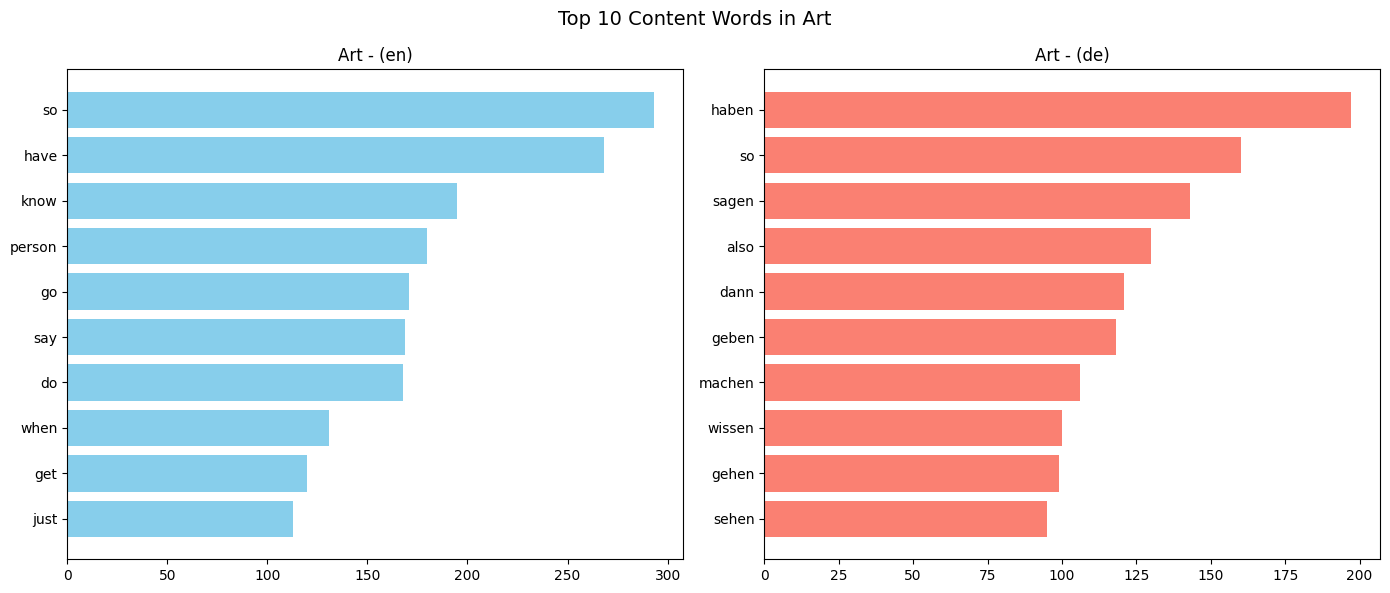

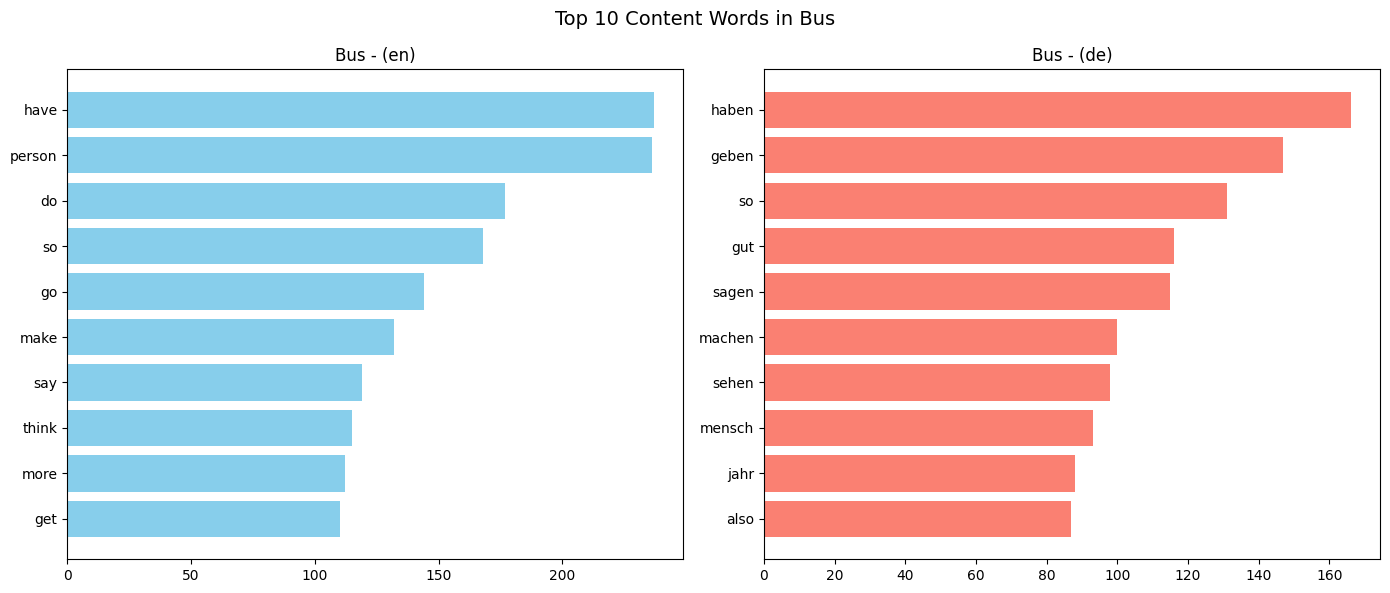

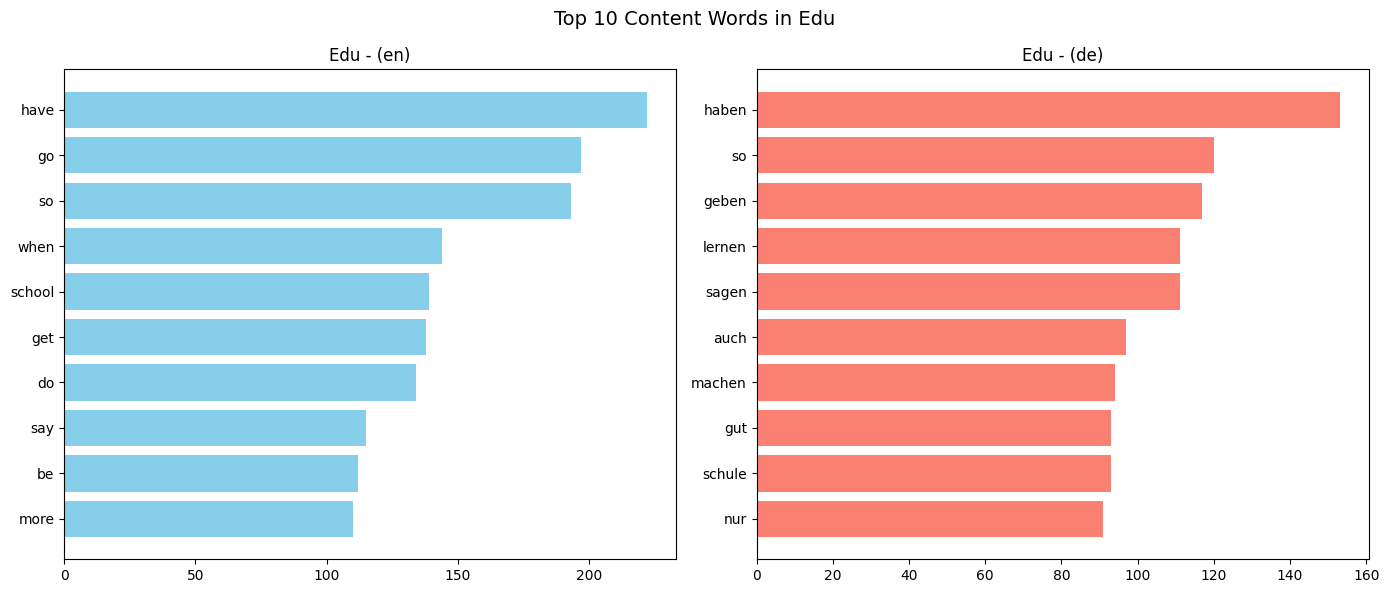

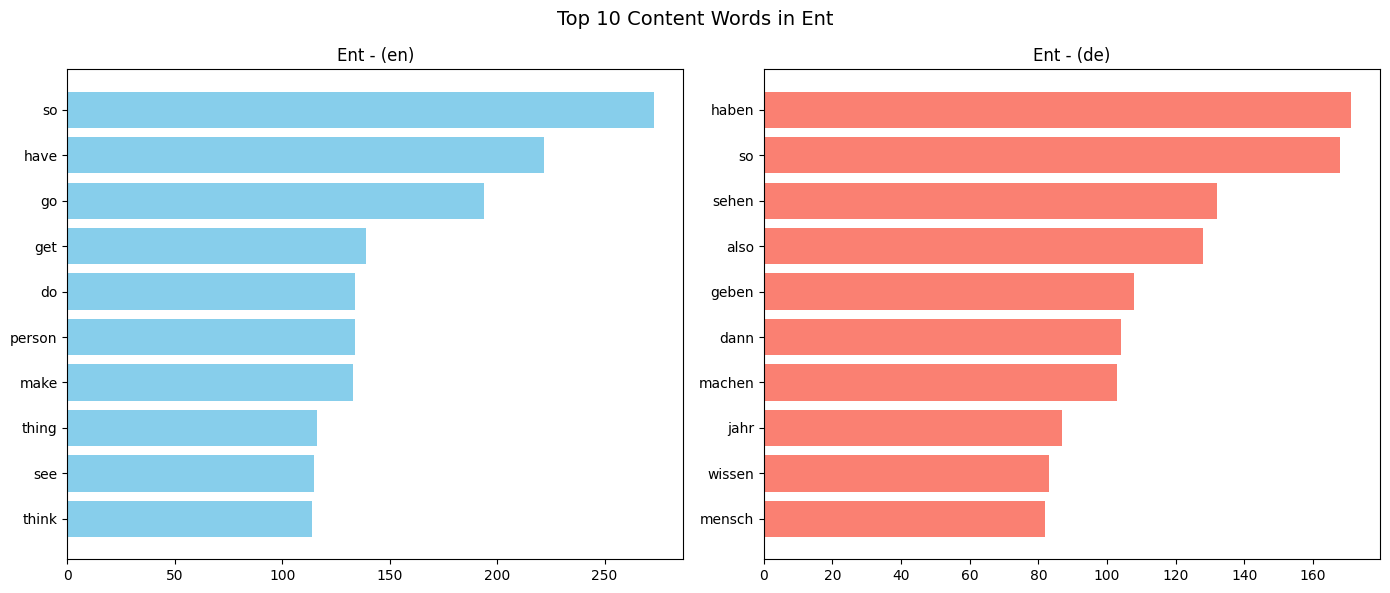

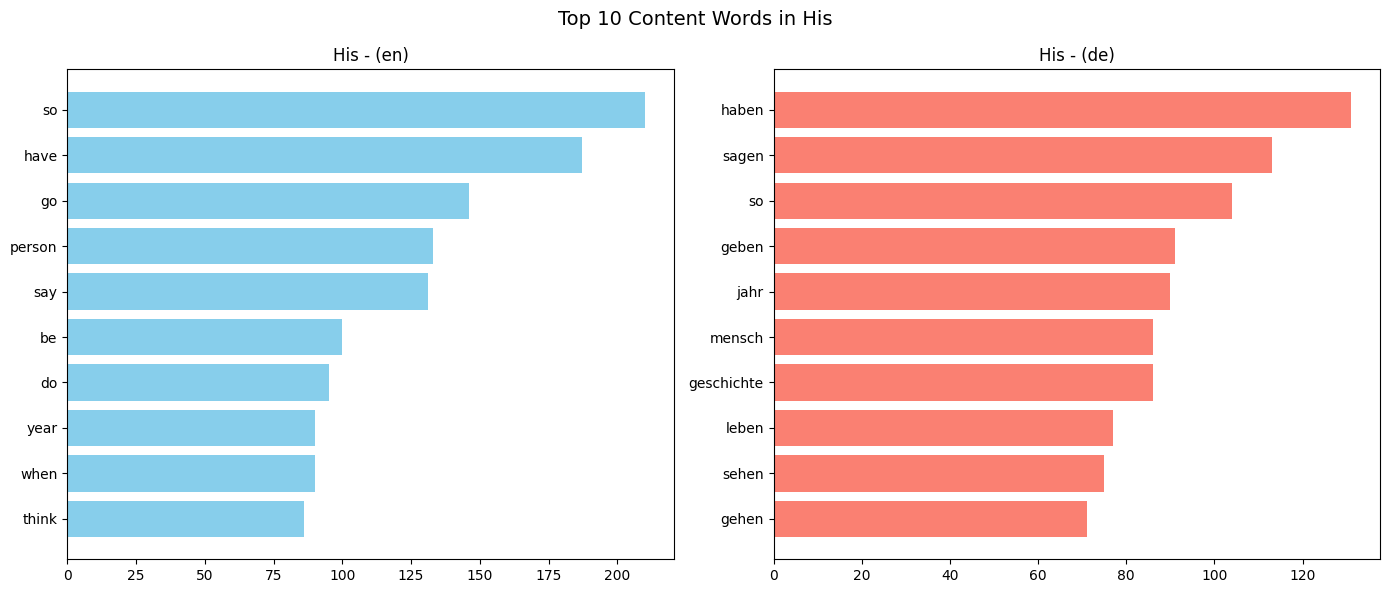

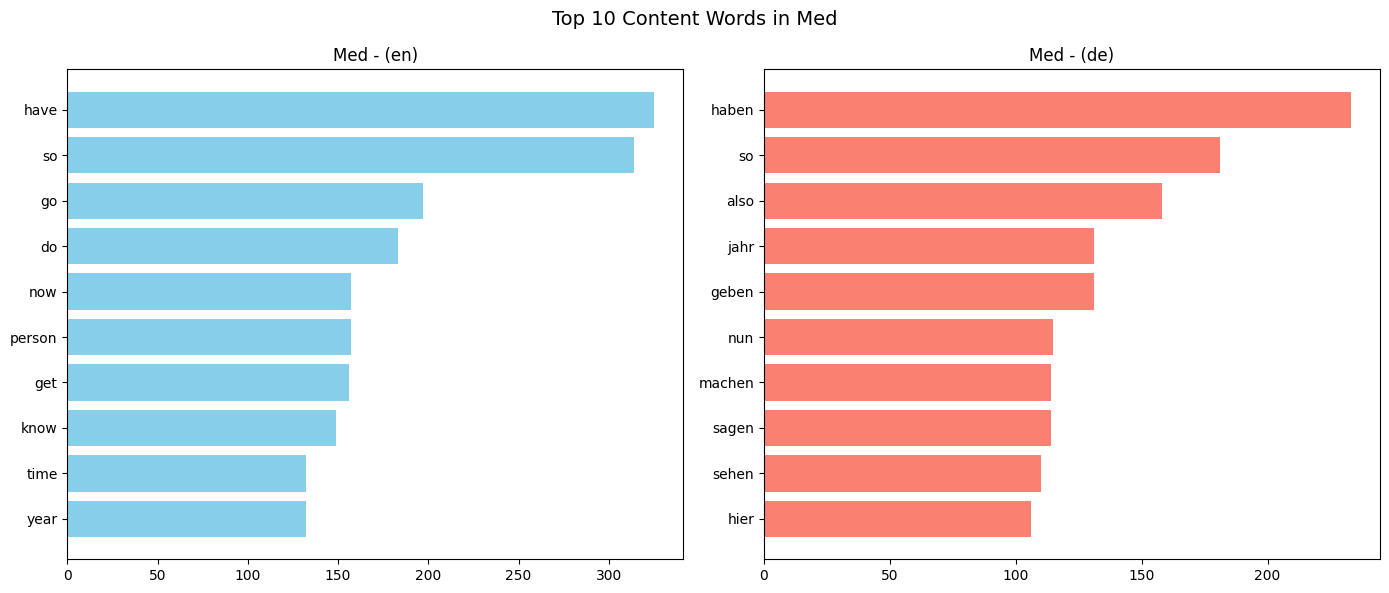

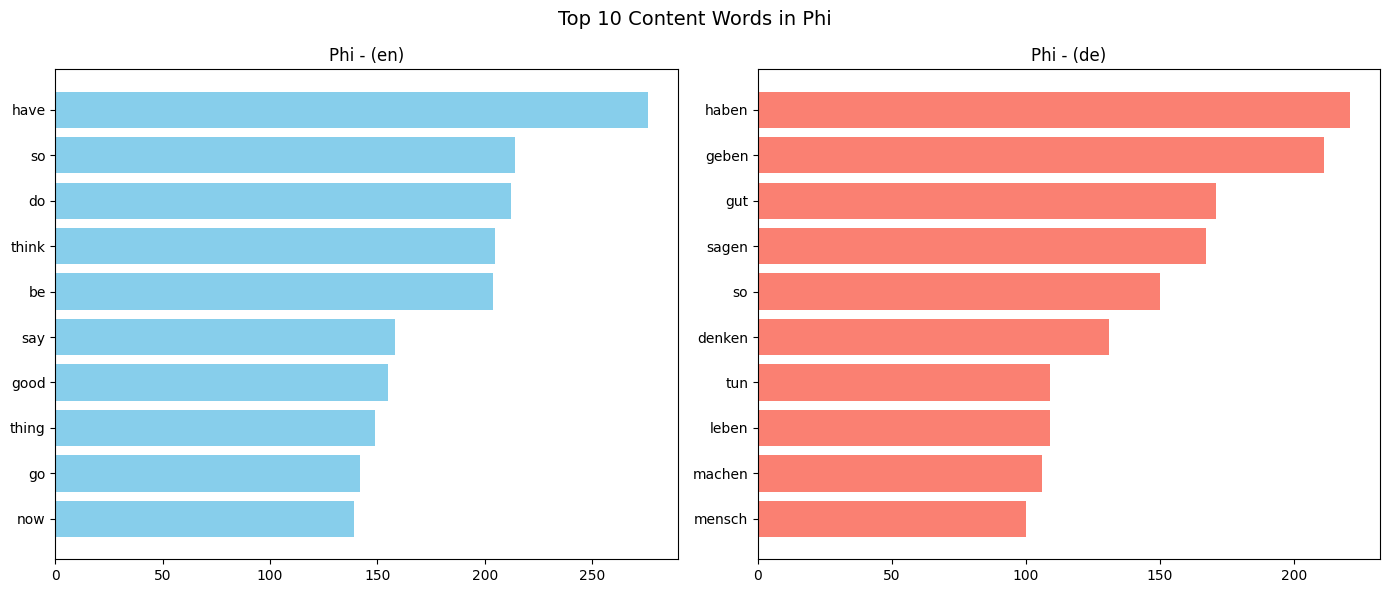

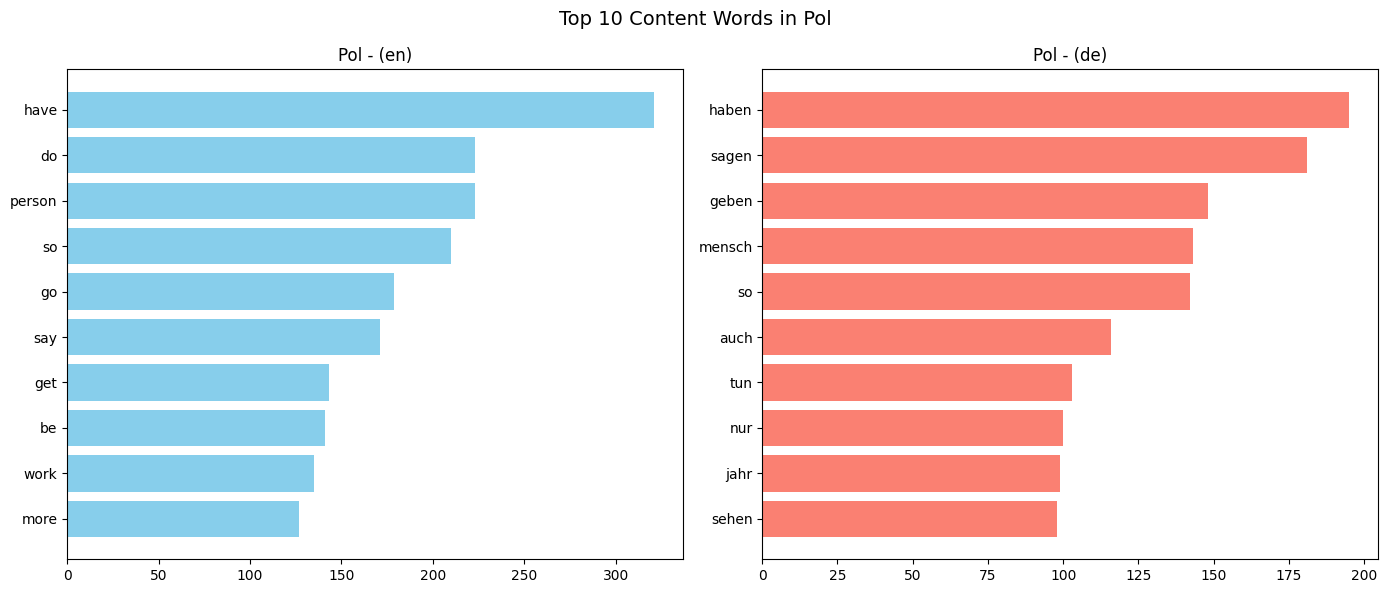

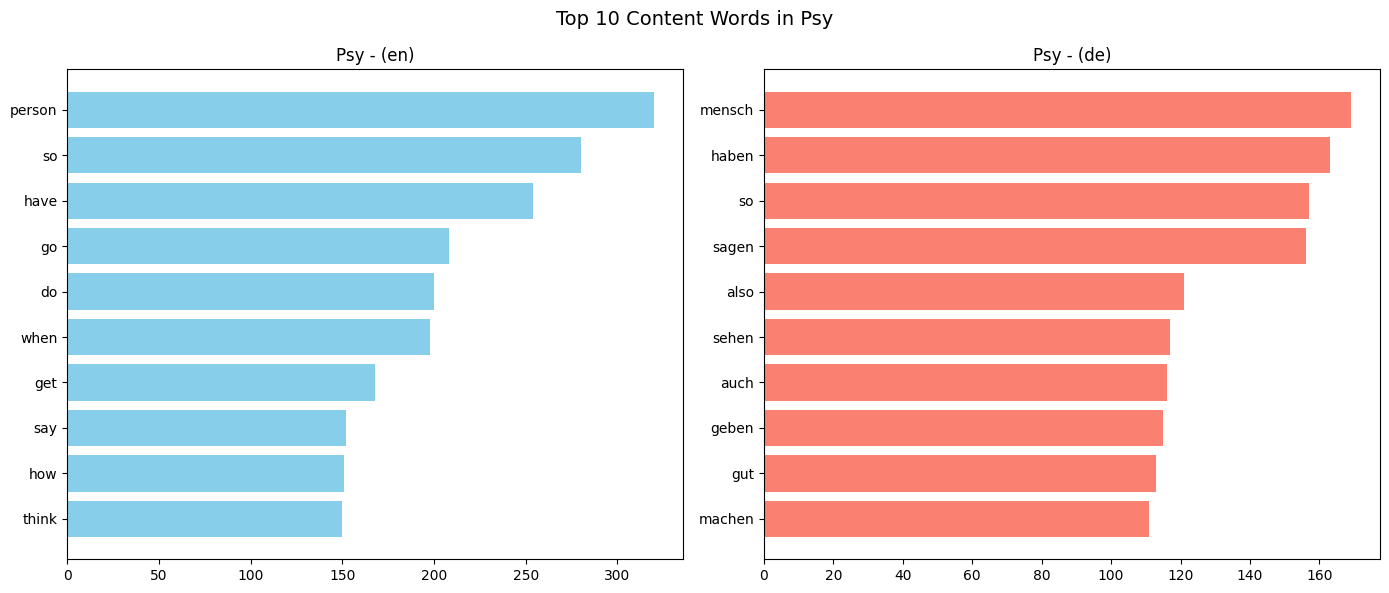

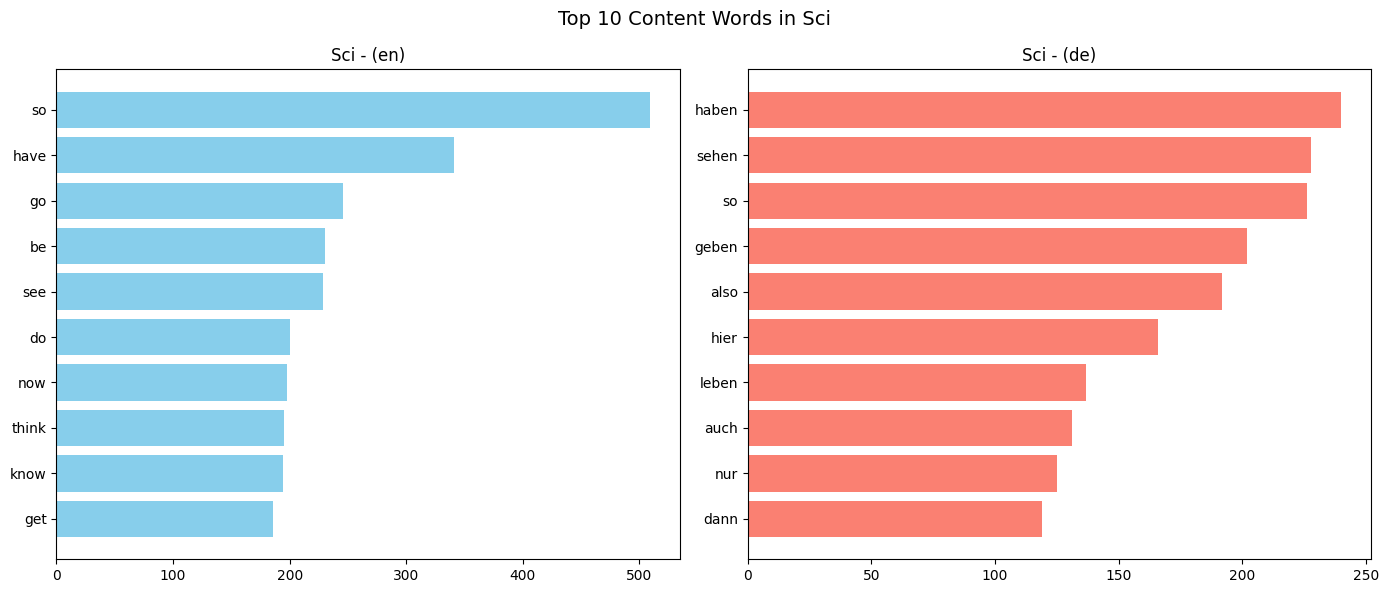

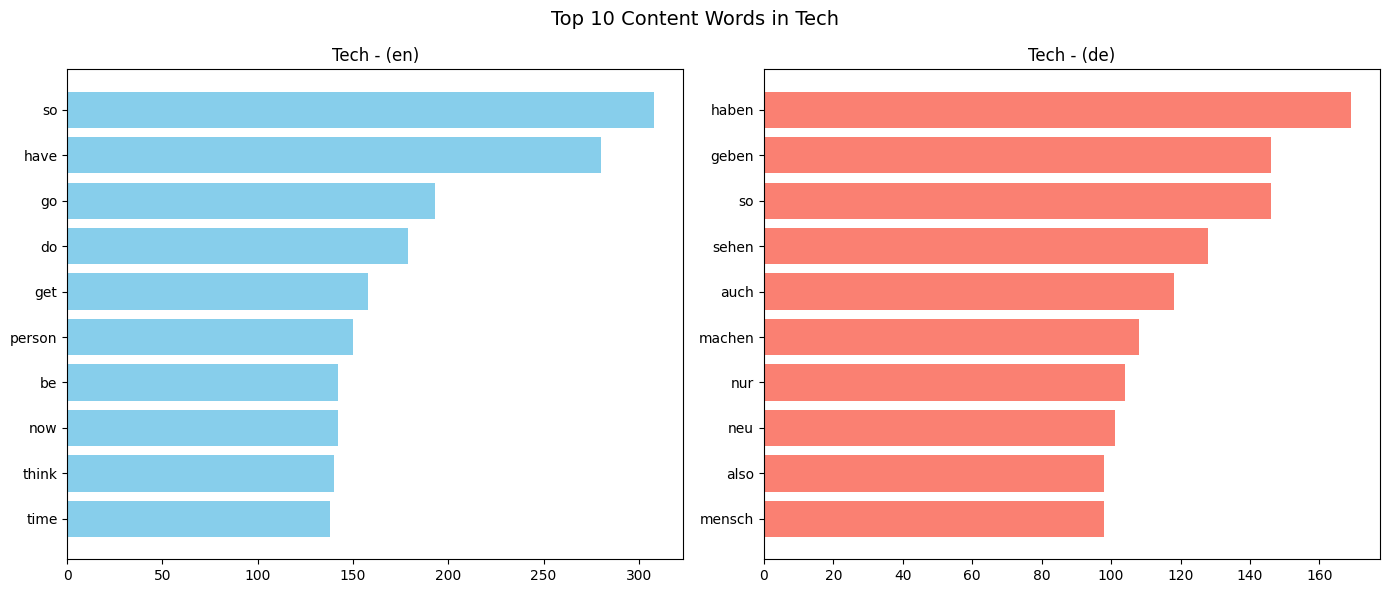

In [37]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

CONTENT_POS = {"NOUN", "PROPN", "ADJ", "VERB", "ADV"}

def collect_content_words(root="conllu/conllu_file", top_n=10):
    """Collect top content words per (lang, discipline)."""
    results = []
    for lang in os.listdir(root):
        lang_path = os.path.join(root, lang)
        if not os.path.isdir(lang_path):
            continue
        for discipline in os.listdir(lang_path):
            disc_path = os.path.join(lang_path, discipline)
            if not os.path.isdir(disc_path):
                continue

            counter = Counter()
            for fname in os.listdir(disc_path):
                if not fname.endswith(".conllu"):
                    continue
                with open(os.path.join(disc_path, fname), "r", encoding="utf-8") as f:
                    for line in f:
                        if not line.strip() or line.startswith("#"):
                            continue
                        parts = line.split("\t")
                        if len(parts) > 3:
                            lemma = parts[2] if parts[2] != "_" else parts[1]
                            upos = parts[3]
                            if upos in CONTENT_POS:
                                counter[lemma.lower()] += 1

            for word, freq in counter.most_common(top_n):
                results.append({
                    "language": lang,
                    "discipline": discipline,
                    "word": word,
                    "count": freq
                })
    return pd.DataFrame(results)

# --- Run extraction
df_content = collect_content_words("conllu/conllu_file", top_n=10)
df_content.to_csv("conllu/top10_content_words_en_de.csv", index=False)
print("CSV saved: conllu/top10_content_words_en_de.csv")
outdir = "plots_content_words"
os.makedirs(outdir, exist_ok=True)

disciplines = sorted(df_content["discipline"].unique())

for disc in disciplines:
    subset = df_content[df_content["discipline"] == disc]

    en = subset[subset["language"] == "en"].sort_values("count", ascending=False).head(10)
    de = subset[subset["language"] == "de"].sort_values("count", ascending=False).head(10)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # English first (skyblue)
    axes[0].barh(en["word"], en["count"], color="skyblue")
    axes[0].set_title(f"{disc} - (en)")
    axes[0].invert_yaxis()

    # German second (salmon)
    axes[1].barh(de["word"], de["count"], color="salmon")
    axes[1].set_title(f"{disc} - (de)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Top 10 Content Words in {disc}", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, disc + ".png"), dpi=150)
    plt.show()


In [39]:
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "conllu/conllu_file"   # adjust if needed
OUT_DIR = "plots_content_words"
os.makedirs(OUT_DIR, exist_ok=True)

# POS set considered as "content words"
CONTENT_POS = {"NOUN", "PROPN", "ADJ", "VERB", "ADV"}


def count_content_words(root):
    overall = Counter()
    by_lang = {}

    for lang in os.listdir(root):
        lang_path = os.path.join(root, lang)
        if not os.path.isdir(lang_path):
            continue
        lang_lower = lang.lower()
        by_lang.setdefault(lang_lower, Counter())

        for disc in os.listdir(lang_path):
            disc_path = os.path.join(lang_path, disc)
            if not os.path.isdir(disc_path):
                continue

            for fname in os.listdir(disc_path):
                if not fname.lower().endswith(".conllu"):
                    continue
                fpath = os.path.join(disc_path, fname)
                try:
                    with open(fpath, "r", encoding="utf-8") as fh:
                        for line in fh:
                            if not line.strip() or line.startswith("#"):
                                continue
                            parts = line.rstrip("\n").split("\t")
                            if len(parts) > 3:
                                upos = parts[3]
                                if upos in CONTENT_POS:
                                    lemma = parts[2] if parts[2] != "_" else parts[1]
                                    token = lemma.strip().lower()
                                    if token:
                                        overall[token] += 1
                                        by_lang[lang_lower][token] += 1
                except Exception as e:
                    print("Warning: failed to read", fpath, e)
    return overall, by_lang


def save_counter_csv_and_plot(counter, csv_path, png_path, top_n=20, title=None, color="tab:blue"):
    top = counter.most_common(top_n)
    df = pd.DataFrame(top, columns=["word", "count"])
    df.to_csv(csv_path, index=False)

    plt.figure(figsize=(8, max(4, 0.25 * len(df))))
    plt.barh(df["word"][::-1], df["count"][::-1], color=color)
    plt.title(title or os.path.basename(png_path))
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    plt.close()
    print("Saved:", csv_path, "and", png_path)


if __name__ == "__main__":
    overall_counter, by_lang_counters = count_content_words(ROOT)

    # Top 20 overall
    save_counter_csv_and_plot(
        overall_counter,
        csv_path=os.path.join(OUT_DIR, "top20_content_words_overall.csv"),
        png_path=os.path.join(OUT_DIR, "top20_content_words_overall.png"),
        top_n=20,
        title="Top 20 Content Words — Overall",
        color="purple"
    )

    # Force English first, then others
    langs_sorted = sorted(by_lang_counters.keys(), key=lambda x: (x != "en", x))

    for lang in langs_sorted:
        counter = by_lang_counters[lang]
        color = "skyblue" if lang == "en" else "salmon" if lang == "de" else "grey"
        save_counter_csv_and_plot(
            counter,
            csv_path=os.path.join(OUT_DIR, f"top20_content_words_{lang}.csv"),
            png_path=os.path.join(OUT_DIR, f"top20_content_words_{lang}.png"),
            top_n=20,
            title=f"Top 20 Content Words — {lang.upper()}",
            color=color
        )

    # Create combined CSV with English first
    rows = []
    top_union = set([w for w, _ in overall_counter.most_common(50)])
    for lang, counter in by_lang_counters.items():
        top_union.update([w for w, _ in counter.most_common(50)])

    for w in sorted(top_union, key=lambda x: -overall_counter.get(x, 0)):
        row = {"word": w, "overall_count": overall_counter.get(w, 0)}
        for lang in langs_sorted:  # English first
            row[f"{lang}_count"] = by_lang_counters[lang].get(w, 0)
        rows.append(row)

    df_all = pd.DataFrame(rows)
    df_all.to_csv(os.path.join(OUT_DIR, "content_word_counts_combined.csv"), index=False)
    print("Combined counts saved to:", os.path.join(OUT_DIR, "content_word_counts_combined.csv"))


Saved: plots_content_words/top20_content_words_overall.csv and plots_content_words/top20_content_words_overall.png
Saved: plots_content_words/top20_content_words_en.csv and plots_content_words/top20_content_words_en.png
Saved: plots_content_words/top20_content_words_de.csv and plots_content_words/top20_content_words_de.png
Combined counts saved to: plots_content_words/content_word_counts_combined.csv


In [ ]:

!zip -r plots_content_words.zip plots_content_words

from google.colab import files
files.download("plots_content_words.zip")
